# Выявление критериев "успешности" продаж компьютерных игр

## 1. Постановка цели и первичный анализ данных

В соответствии с описанием проекта, необходимо:

> _Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании._

**Таким образом, цель реализации проекта можно сформулировать следующим образом:**

Выявление критериев, оказывающих наибольшее влияние на "успешность" компьютерных игр. 

Безусловно, возникает вопрос - какой критерий, на взгляд заказчиков, позволяет охарактеризовать игру как "успешную"? Объем продаж? ROI? Оценка пользователей? Оценка критиков? Единого (и единственного) ответа на данный вопрос нет, поэтому, в рамках реализации проекта мы можем лишь оценить взаимосвязь всех предложенных параметров с другими имеющимися "входными" данными.

Создадим ячейку для подключаемых модулей и перейдем к первичному анализу исходных данных.

In [1]:
import pandas as pd
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from scipy import stats as st

# добавил это условие для того, чтобы скрыть предупреждения, связанные с копированием датафрейма.
pd.options.mode.chained_assignment = None  # default='warn'
# для вывода большого числа столбцов разом
pd.set_option('display.max_columns', 35)

In [2]:
games_sales_rates = pd.read_csv('/datasets/games.csv')
games_sales_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
games_sales_rates.head(15)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


#### 1. Name (Название игры)

Очевидно, что в данном столбце приведено название игры. Судя по info, в столбце имеется 2 пропуска. Теоретически, при наличии информации в других столбцах (рейтинг, жанр, год выхода), данные значения можно восстановить, однако, затраты "время-результат" явно не в пользу данного решения. Всё же значений 2 (из 16+ тысяч) - их устранение на итоговый результат не повлияет. К типу данных вопросов нет.

#### 2. Platform (Платформа)

Здесь - информация об игровой платформе, на которой вышла игра. Пропусков в столбце нет. К типу данных вопросов также нет.

#### 3. Year_of_Release (Год выпуска)

Год выпуска игры на рынок. Есть пропуски, каков их характер пока не понятно. Это могут быть как игры-долгстрои, дату выпуска которых переносили неоднократно, игры, которые так никогда в широкий доступ и не вышли и т.д. Вариантов очень много, нужно смотреть "предметно". Формат данных нужно изменить на целочисленный.

#### 4. Genre (Жанр)

Пропусков также всего 2 на весь столбец - вероятно, для тех же строчек, у которых "нет названия". Тип данных менять не нужно.

#### 5. NA_sales (Продажи в Северной Америке, млн. долларов)

Пропусков нет. Тип данных меня устраивает, на первый взгляд всё в порядке.

#### 6. EU_sales (Продажи в Европе, млн. долларов

Пропусков нет. Тип данных меня устраивает, на первый взгляд всё в порядке.

#### 7. JP_sales (Продажи в Японии, млн. долларов

Пропусков нет. Тип данных меня устраивает, на первый взгляд всё в порядке.

#### 8. Other_sales (Продажи в других странах, млн. долларов)

Пропусков нет. Тип данных меня устраивает, на первый взгляд всё в порядке.

#### 9 - 11. Critic_Score (Оценка критиков), User_Score (Оценка пользователей), Rating (Рейтинг игры)

Пропусков в зависимости от столбца от 40 до 50%. Можно предположить (по "увиденному"), что отсутствие данных характерно для "старых" игр - вышедших до 2000 года, когда оценки и рейтинги играм либо было НЕКОМУ выдавать (игрожурналисты, игрокритики, "ограничители" данной сферы от государства и т.д. отсутствовали как класс - персональная игровая индустрия только-только начинала формироваться - с первыми приставками Нинтендо и Сони).

Другая часть пропусков, вероятно, связана с малой известностью "игр с пропусками" и закономерному отсутствию интереса к ней со стороны широкой публики (ведь на крупных тематических сайтах в основном представлены трафик-магниты - обзоры на те наименования, что у всех на слуху) и критиков. Это подтверждается отсутствием данным в соответствующих столбцах в "хвосте" датасета (см. ниже)

Третья возможная причина возникновения пропусков очень близка ко второй - это отсутствие необходимых данных на информационном ресурсе, с которого они собирались данные. Это применимо только к столбцам-"оценкам", не к столбцу с рейтингом.

Тип данных не подходящий в столбце "Оценка пользователей" - его нужно заменить на "плавающую точку", а также в "Оценке критиков" - там представленны только целочисленные значения - заменим на "целочисленный".

#### P.S.

Также из названий всех представленных столбцов необходимо убрать буквы верхнего регистра - для удобства взаимодействия по ходу реализации проекта.

In [4]:
games_sales_rates.tail(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16705,15 Days,PC,2009.0,Adventure,0.00,0.01,0.00,0.0,63.0,5.8,NaN
16706,Men in Black II: Alien Escape,GC,2003.0,Shooter,0.01,0.00,0.00,0.0,NaN,tbd,T
16707,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16708,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,0.00,0.00,0.00,0.0,NaN,NaN,NaN
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


### Вывод по разделу 1

В целом представленные данные выглядят достойно и, на первый взгляд, не содержат критических ошибок и недочетов, которые невозможно исправить на этапе предобработки данных. Переходим к предобработке данных :)

## 2. Предварительная обработка данных

Начнем с изменения названий столбцов с учетом "нижнего регистра".

In [5]:
table_columns = games_sales_rates.columns
table_columns_lower= [element.lower() for element in table_columns]
games_sales_rates.columns = table_columns_lower

# меняю тип столбцов
# games_sales_rates['year_of_release'] = games_sales_rates['year_of_release'].astype('int')
# games_sales_rates['user_score'] = games_sales_rates['user_score'].astype('float')

games_sales_rates.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Теперь займемся устранением пропусков в столбцах. Пропуски в столбцах "Имя" и "Жанр" просто удалим.

In [6]:
games_sales_rates = games_sales_rates[games_sales_rates['name'].isna() == False].reset_index(drop = True)
games_sales_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Вместе с пропуском в "Имени" датасет покинули и пропуски в столбце "Жанр". Идеально. Переходим к столбцу "Год выпуска". Для начала посмотрим на состояние данных с пропусками в данном столбце.

In [7]:
games_sales_rates[games_sales_rates['year_of_release'].isna() == True].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
677,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
718,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
804,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


Итак, у нас целых 269 строчек с пропусками года выпуска. В чем причина возникновения таких пропусков?
Пока лучше варианта, чем ошибка при сборе данных у меня нет. Тем не менее, у меня также есть и решение для некоторых из представленных наименований. Речь идёт о играх-"регулярах" вроде симуляторов хоккея, баскетбола, футбола, рестлинга и т.д.
Как правило, год их выпуска на 1 (единицу) меньше года, указанного в названии. Т.е. если ФИФА 2004, то вышла она в 2003 году. Если Смэкдаун 2006, то вышел он в 2005 году и т.д.
В принципе, мы можем провернуть этот трюк собрал смыслоформы из названий и, затем, выделив число, уменьшить его на единицу. И полученное значение присвоить столбцу год выпуска. Вопрос в другом - насколько нам важно сохранение 200+ строк данных при наличии 16+ тысяч таких строк? Не существенно (0.5% всё-таки), но если есть возможность оперативно вернуть их в строй, это можно сделать. 

В первую очередь, для создания массива с искомыми значениями (годами выпуска игр), нам необходимо убрать пропуски в столбце "Год выпуска". Заменим их на 0 и сделаем тип данных целочисленным.

In [8]:
games_sales_rates['year_of_release'] = games_sales_rates['year_of_release'].fillna(0).astype('int')
games_sales_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB


Теперь сформируем срез по тем строчкам, для которых отсутствовало значение года (теперь это значение = 0)

In [9]:
games_no_year = games_sales_rates[games_sales_rates['year_of_release'] == 0]
games_no_year.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,0,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,0,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,0,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,0,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,0,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,0,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
677,LEGO Indiana Jones: The Original Adventures,Wii,0,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
718,Call of Duty 3,Wii,0,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
804,Rock Band,Wii,0,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


Теперь нарежем названия игр на леммы. Словоформы как таковые нас не интересуют - всё что нам нужно (в первую и единственную очередь) - это год, фигурирующий в названии игры. 

In [10]:
m = Mystem()

def names_lemmatize(name):
    name_list = m.lemmatize(name)
    return name_list

games_no_year['lemmas'] = games_no_year['name'].apply(names_lemmatize)
games_no_year.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,lemmas
183,Madden NFL 2004,PS2,0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,"[Madden, , NFL, , 2004, \n]"
377,FIFA Soccer 2004,PS2,0,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,"[FIFA, , Soccer, , 2004, \n]"
456,LEGO Batman: The Videogame,Wii,0,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,"[LEGO, , Batman, : , The, , Videogame, \n]"
475,wwe Smackdown vs. Raw 2006,PS2,0,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,"[wwe, , Smackdown, , vs, . , Raw, , 2006, \n]"
609,Space Invaders,2600,0,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,"[Space, , Invaders, \n]"


Видим, что операция "Лемматизация" прошла успешно и у нас теперь есть значение года, как отдельного элемента списка (столбец "lemmas". Для этого воспользуемся методом isdigit(), который проверяет, является ли значение строки числом. Сформируем столбец с числами, извлеченными из лемматизированных строк.

In [11]:
def lkng_fr_year(aparted_name):
    for part in aparted_name:
        if part.isdigit() == True:
            if int(part) > 1950:
                return part
games_no_year['finded_year'] = games_no_year['lemmas'].apply(lkng_fr_year)
games_no_year.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,lemmas,finded_year
183,Madden NFL 2004,PS2,0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,"[Madden, , NFL, , 2004, \n]",2004
377,FIFA Soccer 2004,PS2,0,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,"[FIFA, , Soccer, , 2004, \n]",2004
456,LEGO Batman: The Videogame,Wii,0,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,"[LEGO, , Batman, : , The, , Videogame, \n]",None
475,wwe Smackdown vs. Raw 2006,PS2,0,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,"[wwe, , Smackdown, , vs, . , Raw, , 2006, \n]",2006
609,Space Invaders,2600,0,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,"[Space, , Invaders, \n]",None


Столбец получен, посмотрим, сколько значений нам "удалось спасти". 

In [12]:
games_no_year['finded_year'].count()

17

17 строчек. Стоит ли игра свеч? Возможно. Проведем запланированную операцию по восстановлению года для ряда наименований. Значение года = (извлеченный год - 1). Но перед этим, по традиции, заменим пропуски на индикаторные значение. Например, 0.

In [13]:
def year_calc(fndd_year):
    if fndd_year != 0:
        real_year = int(fndd_year) - 1
        return real_year
    else:
        return 0

games_no_year['finded_year'] = games_no_year['finded_year'].fillna(0).astype('int')
games_no_year['year_of_release'] = games_no_year['finded_year'].apply(year_calc).astype('int')
games_no_year.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,lemmas,finded_year
183,Madden NFL 2004,PS2,2003,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,"[Madden, , NFL, , 2004, \n]",2004
377,FIFA Soccer 2004,PS2,2003,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,"[FIFA, , Soccer, , 2004, \n]",2004
456,LEGO Batman: The Videogame,Wii,0,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,"[LEGO, , Batman, : , The, , Videogame, \n]",0
475,wwe Smackdown vs. Raw 2006,PS2,2005,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,"[wwe, , Smackdown, , vs, . , Raw, , 2006, \n]",2006
609,Space Invaders,2600,0,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,"[Space, , Invaders, \n]",0


Внесём наш "исправленный" массив внутрь имеющегося и избавимся от ненужных столбцов.

In [14]:
games_sales_rates_bigger = games_sales_rates.merge(games_no_year, how = 'outer')
games_sales_rates_bigger = games_sales_rates_bigger.drop(['lemmas', 'finded_year'], axis = 1)
games_sales_rates_bigger.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16730 entries, 0 to 16729
Data columns (total 11 columns):
name               16730 non-null object
platform           16730 non-null object
year_of_release    16730 non-null int64
genre              16730 non-null object
na_sales           16730 non-null float64
eu_sales           16730 non-null float64
jp_sales           16730 non-null float64
other_sales        16730 non-null float64
critic_score       8149 non-null float64
user_score         10026 non-null object
rating             9960 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Игры с пропусками в столбце "Год выпуска" могут нас интересовать исключительно с точки зрения приставок, на которых они выходили - для сохранения точности в определении развеса (а значит и "любви" пользователей) данных в зависимости от приставки. Тем не менее, нули могут создать ненужный нам шум при анализе данных с иных точек зрения. Потому, создадим новый датасет без "нулевых" годов, а предшествующий будем иметь в виду и воспользуемся им при необходимости.

In [15]:
games_no_zero_year = games_sales_rates_bigger[
    games_sales_rates_bigger['year_of_release'] != 0].reset_index(drop = True)
games_no_zero_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16461 entries, 0 to 16460
Data columns (total 11 columns):
name               16461 non-null object
platform           16461 non-null object
year_of_release    16461 non-null int64
genre              16461 non-null object
na_sales           16461 non-null float64
eu_sales           16461 non-null float64
jp_sales           16461 non-null float64
other_sales        16461 non-null float64
critic_score       7995 non-null float64
user_score         9851 non-null object
rating             9779 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB


С пропусками в году выпуска, названии и жанрах разобрались. Переходим к столбцам рейтингового типа. Посмотрим, на то, в каких временных границах выпускались имеющиеся у нас для анализа игры. 

In [16]:
games_no_zero_year['year_of_release'].describe()

count    16461.000000
mean      2006.484600
std          5.873512
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

Итак, у нас есть данные за 36 лет - с 1980 по 2016 гг. включительно. Проверим нашу гипотезу, относительно причин возникновения пропусков в заявленных столбцах.

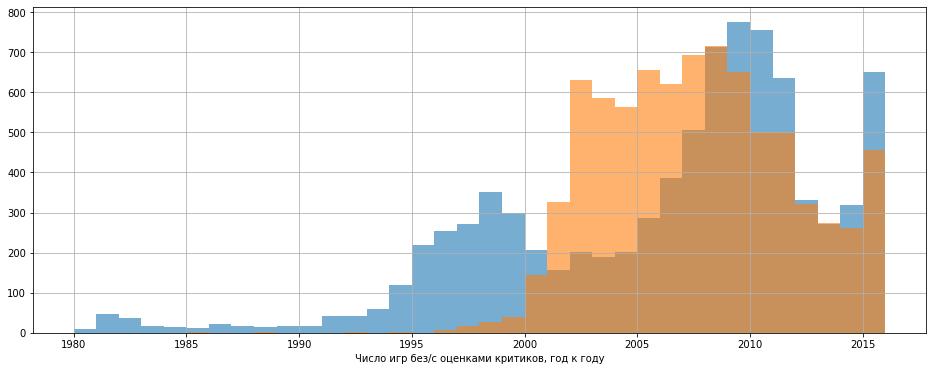

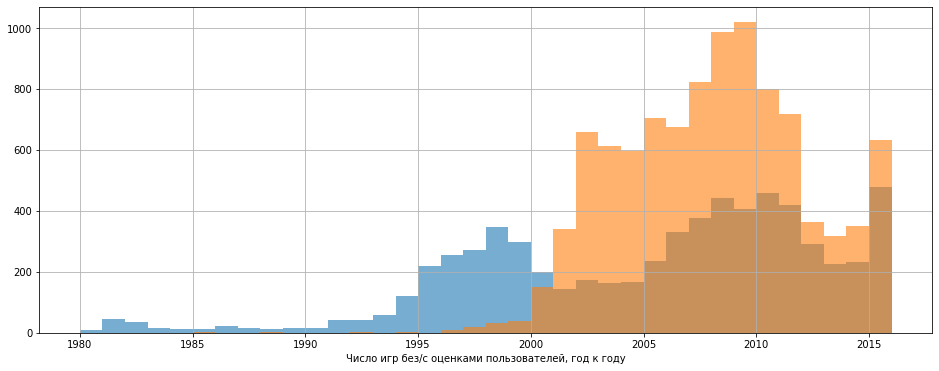

In [17]:
games_no_zero_year[games_no_zero_year['critic_score']
                   .isna() == True]['year_of_release'].hist(bins = 36, range = (1980, 2016),
                                                            alpha = 0.6, figsize = (16,6))
games_no_zero_year[games_no_zero_year['critic_score']
                   .isna() == False]['year_of_release'].hist(bins = 36, range = (1980, 2016), 
                                                             alpha = 0.6, figsize = (16,6))
plt.xlabel("Число игр без/с оценками критиков, год к году")

plt.show()
games_no_zero_year[games_no_zero_year['user_score']
                   .isna() == True]['year_of_release'].hist(bins = 36, range = (1980, 2016), 
                                                            alpha = 0.6, figsize = (16,6))
games_no_zero_year[games_no_zero_year['user_score']
                   .isna() == False]['year_of_release'].hist(bins = 36, range = (1980, 2016), 
                                                             alpha = 0.6, figsize = (16,6))
plt.xlabel("Число игр без/с оценками пользователей, год к году")
plt.show()


Как я и предполагал, часть отсутствующих значений в данном столбце связана с банальным отсутствием соответствующих институтов в рамках отрасли. Первые "обзоры, отзывы, критика", согласно имеющемуся датасету, появились в 1996 году. Как следствие, для игр, выпущенных ранее 1996 года, единственным критерием оценки интереса пользователей является объем продаж. 

Начиная с 1996 года число "оценочных суждений" (как наличествующих, так и отсутствующих) начало расти, следуя общему тренду увеличения числа выпускаемых компьютерных игр. Соответственно, для игр, выпущенных после 1996 года (включительно) в качестве критерия "успешности" также следует рассматривать эти самые оценки пользователей. Осуществим "разнородную" индикаторную замену - для игр ранее 1996 года - одно значение (например, 999, т.к. отсутствие отзывов к играм в те годы не значит, что они были "плохи"), чтобы иметь возможность в будущем "запросто" отделить их от общего массива. А для игр после 1996 года - другое значение (например, 0, т.к. здесь причины отсутствия "отзывов" иные). Индикаторные значения сделаем единые для обоих столбцов - и критиков, и пользователей.

Для удобства замены и дальнейшей работы, разделим датасет на 2 - игры до 1995 года (включительно) и игры после 1996 года (тоже включительно). 

In [18]:
games_before_1995 = games_no_zero_year[games_no_zero_year['year_of_release'] <= 1995]
games_after_1996 = games_no_zero_year[games_no_zero_year['year_of_release'] >= 1996]

print("В базе данных содержится",games_before_1995['year_of_release'].count(),
      "игр, выпущенных до 1996 года.")
print("А также",games_after_1996['year_of_release'].count(),
      "игр, выпущенных после 1996 года.")

В базе данных содержится 705 игр, выпущенных до 1996 года.
А также 15756 игр, выпущенных после 1996 года.


Налицо существенное расхождение в количестве выпущенных игр - 705 против 15756. Произведем необходимые замены. Индексы пока оставим без изменения - для возможности последующей склейки датасетов.

In [19]:
# критики
games_before_1995['critic_score'] = games_before_1995['critic_score'].fillna(999).astype('int')
games_after_1996['critic_score'] = games_after_1996['critic_score'].fillna(0).astype('int')

# пользователи
games_before_1995['user_score'] = games_before_1995['user_score'].fillna(999).astype('float')
games_after_1996['user_score'] = games_after_1996['user_score'].fillna(0)

games_after_1996.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15756 entries, 0 to 16460
Data columns (total 11 columns):
name               15756 non-null object
platform           15756 non-null object
year_of_release    15756 non-null int64
genre              15756 non-null object
na_sales           15756 non-null float64
eu_sales           15756 non-null float64
jp_sales           15756 non-null float64
other_sales        15756 non-null float64
critic_score       15756 non-null int64
user_score         15756 non-null object
rating             9774 non-null object
dtypes: float64(4), int64(2), object(5)
memory usage: 1.4+ MB


При попытке заменить тип данных в столбце "Оценка пользователей" датасета с играми, выпущенными после 1996 года, на "с плавающей точкой", получаю ошибку - о невозможности сконвертировать в необходимый тип ячеек, содержащих значение "tbd". Посмотрим на эти строки и примем решение, что с ними делать.

In [20]:
games_after_1996[games_after_1996['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,0,tbd,E
300,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61,tbd,E10+
516,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,0,tbd,T
639,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71,tbd,E
709,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16427,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48,tbd,E
16433,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,0,tbd,E
16435,Men in Black II: Alien Escape,GC,2003,Shooter,0.01,0.00,0.0,0.00,0,tbd,T
16450,NFL GameDay 2003,PS2,2002,Sports,0.20,0.15,0.0,0.05,60,tbd,E


Таких значений - 2378 штук! В данном контексте "tbd" следует понимать как "to be determined", т.е. "Будет определено". Наиболее вероятной причиной их возникновения является банальная нехватка отзывов пользователей - т.е. с одной стороны, отзывы есть. Но, с другой стороны, алгоритмы, рассчитывающие рейтинг (пользователей, на основании множества оценок) содержат более высокий количественный "порог входа в рейтинг". Допустим, на игру оставили отзывы 100 человек, а статистически достоверная оценка (исключительно с точки зрения платформы, агрегирующей компьютерные игры и их оценки) - с выбросом "хейтеров", "ботов" и прочих асоциальных элементов, возможна только при наличии 1000 отзывов. Потом, к 2016 году, игры от 2002 года до сих пор висят с оценкой "tbd". Я считаю, что в данном случае, оценка "tbd" идентична оценке 0 - а именно, отсутствию оценки со стороны пользователей. Конечно тот факт, что не удалось собрать достаточное количество оценок, совершенно не указывает на качество игры - вполне вероятно, она весьма и весьма хороша. Тем не менее, с точки зрения продаж такие проекты не представляют большого интереса. Потому, я принял решение заменить все таковые значение в столбце "Оценка пользователей" на нули. Сделаем это и перейдем к столбцу "Рейтинг".

In [21]:
games_after_1996['user_score'] = games_after_1996['user_score'].replace('tbd', 0).astype('float')
games_after_1996.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15756 entries, 0 to 16460
Data columns (total 11 columns):
name               15756 non-null object
platform           15756 non-null object
year_of_release    15756 non-null int64
genre              15756 non-null object
na_sales           15756 non-null float64
eu_sales           15756 non-null float64
jp_sales           15756 non-null float64
other_sales        15756 non-null float64
critic_score       15756 non-null int64
user_score         15756 non-null float64
rating             9774 non-null object
dtypes: float64(5), int64(2), object(4)
memory usage: 1.4+ MB


Для начал посмотрим, какие значения встречаются в столбце рейтинг. Согласно википедии, таких вариантов может быть всего 7 (с учетом "в процессе определения").

In [22]:
games_after_1996['rating'].value_counts()

E       3930
T       2902
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

E - Для всех. В списке имеется. Оставляем? Безусловно.
T - Для подростков (13+). Такой вариант также есть. Оставляем? Да.
М - Для взрослых (подростков) (17+). Значений достаточно, оставляем. 
Е10+ - Для всех (но 10+). Также оставляем.

Ещё 4 типа "рейтинга" практически не представлены - имеет ли смысл их оставлять - нет. их несравнимо меньше, чем интересующих нас значений. Их анализ не даст сколько угодно значимых результатов. Но удалять мы их тоже не будем, а заменим, как и все остальные пропуски, на значения "None" - отсутствие рейтинга.

In [23]:
games_after_1996['rating'] = games_after_1996['rating'].replace(['EC', 'K-A', 'AO', 'RP'], 'None')
games_after_1996['rating'] = games_after_1996['rating'].fillna("None")

games_after_1996['rating'].value_counts()

None    5995
E       3930
T       2902
M       1536
E10+    1393
Name: rating, dtype: int64

Посмотрим на пропуски теперь.

In [24]:
games_after_1996.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15756 entries, 0 to 16460
Data columns (total 11 columns):
name               15756 non-null object
platform           15756 non-null object
year_of_release    15756 non-null int64
genre              15756 non-null object
na_sales           15756 non-null float64
eu_sales           15756 non-null float64
jp_sales           15756 non-null float64
other_sales        15756 non-null float64
critic_score       15756 non-null int64
user_score         15756 non-null float64
rating             15756 non-null object
dtypes: float64(5), int64(2), object(4)
memory usage: 1.4+ MB


Переходим к датасету с играми до 1996 года.

In [25]:
print(games_before_1995['rating'].value_counts())
print()
games_before_1995.info()

T       3
M       1
E10+    1
Name: rating, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 1 to 16395
Data columns (total 11 columns):
name               705 non-null object
platform           705 non-null object
year_of_release    705 non-null int64
genre              705 non-null object
na_sales           705 non-null float64
eu_sales           705 non-null float64
jp_sales           705 non-null float64
other_sales        705 non-null float64
critic_score       705 non-null int64
user_score         705 non-null float64
rating             5 non-null object
dtypes: float64(5), int64(2), object(4)
memory usage: 66.1+ KB


5 значений из 705 в наличии. Все представленные типы - из "одобренных ранее". Заменим пропуски нулями и продолжим движение по проекту.

In [26]:
games_before_1995['rating'] = games_before_1995['rating'].fillna("None")

games_before_1995['rating'].value_counts()

None    700
T         3
M         1
E10+      1
Name: rating, dtype: int64

Готово. Объединим датасеты в обратную сторону и переходим к следующему пункту задания - посчитаем суммарные продажи во всех регионах.

In [27]:
games_fill = games_after_1996.merge(games_before_1995, how = 'outer')
games_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16461 entries, 0 to 16460
Data columns (total 11 columns):
name               16461 non-null object
platform           16461 non-null object
year_of_release    16461 non-null int64
genre              16461 non-null object
na_sales           16461 non-null float64
eu_sales           16461 non-null float64
jp_sales           16461 non-null float64
other_sales        16461 non-null float64
critic_score       16461 non-null int64
user_score         16461 non-null float64
rating             16461 non-null object
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


In [28]:
games_fill['sales'] = (games_fill['na_sales'] + games_fill['eu_sales'] 
                       + games_fill['jp_sales'] + games_fill['other_sales'])
games_fill.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
2,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
3,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,None,31.38
4,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80


### Вывод по разделу 2

Были заполнены пропуски, изменены типы данных там, где это было необходимо (преимущественно, для снижения затрат памяти), а также устранены возможные "шумы" в предшествующем анализе данных. На основании наличия / отсутствия рейтинга и оценок выделено 2 группы игры - выпущенных до 1995 года (включительно) и после 1996 года (включительно). Рейтинг и оценки, преимущественно, появились "как класс" после 1995 года. До этого их практически (99,99%) не было.

В таблицу добавлен расчетный столбец, содержащий значения суммарной выручки для каждой игры по всем регионам.

## 3. Исследовательский анализ данных

### 1. Год выпуска
Посмотрим, сколько игр выпускалось в разные годы.

Построим гистограмму по годам.

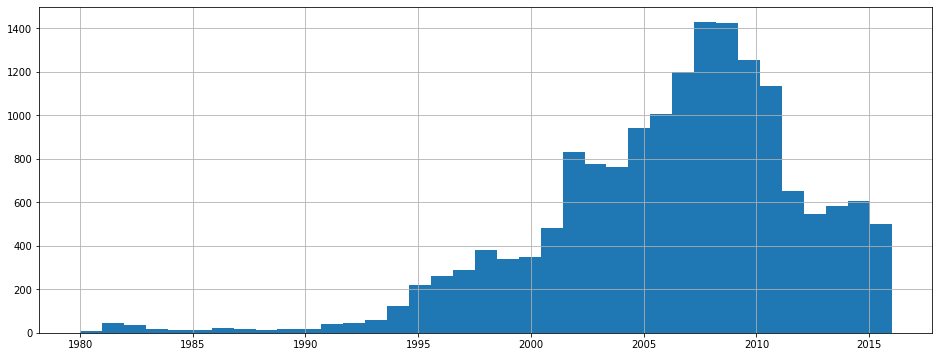

In [29]:
games_fill['year_of_release'].hist(bins = 37, figsize = (16,6))

На гистограмме отчетливо видно, что восходящий тренд на количество выпускаемых игр начинает свой путь в 1993-1994 году. До этого, компьютерные игры относились скорее к "маргинальной" части мира и были развлечением для "гиков" - т.е. не имели массового характера. По этой причине, часть данных (по году выпуска) следует попросту отбросить - в связи с отсутствием статистической значимости. Полученная гистограмма имеет вид нормального распределения - с пиком в районе 2008-2009 гг. и "зарождающимся" пиком в 2016 году. Определим нижнюю границу (по году) интересующего нас распределения. 

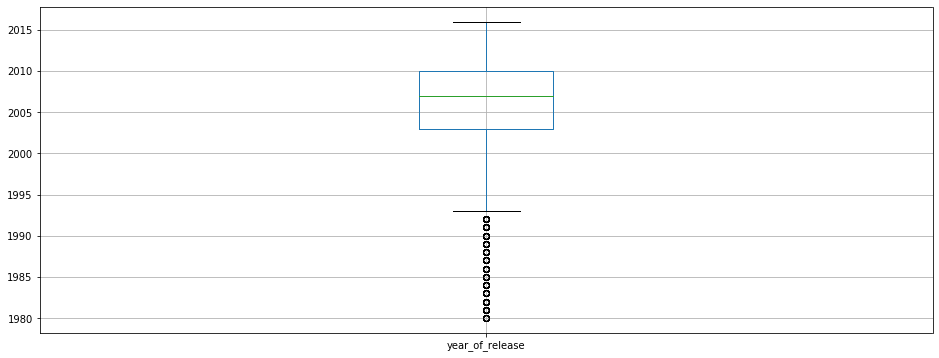

In [30]:
games_fill.boxplot(column = ['year_of_release'], figsize = (16,6))

Наше предположение подтверждено. Все игры, выпущенные ранее 1993 года (не включительно) можно выбросить из анализа. Так и сделаем.

In [31]:
games_fill_after_1993 = games_fill[games_fill['year_of_release'] >= 1993]
games_fill_after_1993

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
2,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
3,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,None,31.38
4,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
...,...,...,...,...,...,...,...,...,...,...,...,...
16454,Ginga Fukei Densetsu: Sapphire,TG16,1995,Shooter,0.00,0.00,0.02,0.00,999,999.0,None,0.02
16455,Super Dodge Ball,NG,1995,Sports,0.00,0.00,0.02,0.00,999,999.0,None,0.02
16457,World Class Rugby 2: Kokunai Gekitou Hen '93,SNES,1994,Sports,0.00,0.00,0.02,0.00,999,999.0,None,0.02
16459,Rock N' Roll Racing,SNES,1993,Racing,0.00,0.00,0.01,0.00,999,999.0,None,0.01


Выбросили около 250 значений. Построим обновленную гистограмму и продолжим анализ.

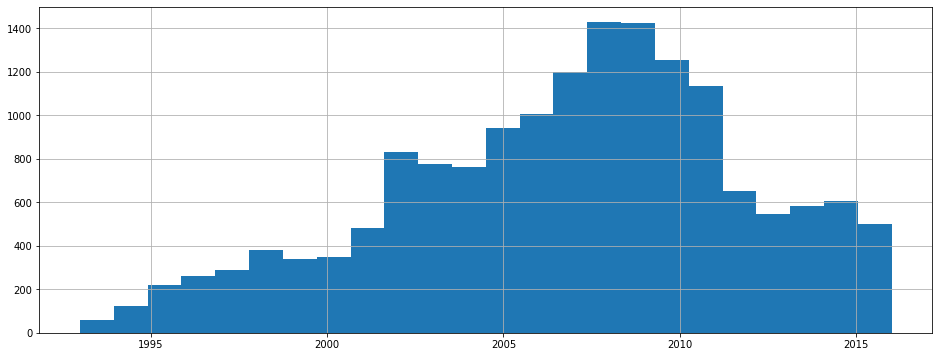

In [32]:
games_fill_after_1993['year_of_release'].hist(range = (1993, 2016), bins = 24, figsize = (16,6))

### 2. Платформа

Переходим к анализу выпуска игр с точки зрения платформы. Сгруппируем данные по платформе и посмотрим на то, сколько игр выпускалось в различные годы. Воспользуемся сводными таблицами.

In [33]:
games_platf_year = games_fill_after_1993.pivot_table(index = 'platform', columns = 'year_of_release', 
                                  values = 'name', aggfunc = ('count')).fillna(0).astype('int')
games_platf_year.head(10)

year_of_release,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,,,,
3DO,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3DS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116,93,91,80,86,46
DC,0,0,0,0,0,7,14,20,8,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
DS,0,0,0,0,0,0,0,0,0,0,0,23,118,201,377,492,403,323,153,23,8,0,0,0
GB,0,3,4,6,8,8,11,17,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GBA,0,0,0,0,0,0,0,1,107,198,150,175,135,39,6,0,0,0,0,0,0,0,0,0
GC,0,0,0,0,0,0,0,0,22,153,144,83,97,40,4,0,0,0,0,0,0,0,0,0
GEN,7,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
N64,0,0,0,18,49,77,102,60,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


По представленным данным наглядно видно, как "появлялись" и "умирали" платформы - жизненный цикл налицо. 
Создадим аналогичную таблицу, но не по количеству игр, а по суммарным продажам этих игр в зависимости от платформы и года. Добавим в неё столбец с суммарными продажами по платформе.

In [34]:
games_platf_year_sales = games_fill_after_1993.pivot_table(index = 'platform', columns = 'year_of_release',  
                                  values = 'sales', aggfunc = ('sum')).fillna(0)
games_platf_year_sales['all_time'] = games_platf_year_sales.sum(axis = 1)
games_platf_year_sales.head(5)

year_of_release,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,all_time
platform,,,,,,,,,,,,,,,,,,,,,,,,,
3DO,0.0,0.02,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10
3DS,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,63.20,51.36,56.57,43.76,27.78,15.14,257.81
DC,0.0,0.00,0.00,0.00,0.00,3.38,5.16,5.99,1.07,0.29,0.0,0.00,0.00,0.00,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.95
DS,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,17.27,130.14,119.81,146.95,145.31,119.54,85.02,26.18,11.01,1.54,0.00,0.00,0.00,802.77
GB,0.0,12.18,3.60,36.03,6.37,26.90,38.00,19.76,9.24,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,152.08


Отсортируем полученную таблицу по столбцу с суммарными продажами.

In [35]:
games_platf_year_sales = games_platf_year_sales.sort_values(by = 'all_time', ascending = False)
games_platf_year_sales.head(5)

year_of_release,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,all_time
platform,,,,,,,,,,,,,,,,,,,,,,,,,
PS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.17,166.43,207.0,193.05,212.13,163.70,103.42,75.99,53.90,26.40,5.64,0.45,0.00,0.00,0.00,0.00,0.00,1247.28
X360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,8.25,51.63,95.41,135.26,120.29,170.08,143.84,99.74,88.58,34.74,11.96,1.52,961.30
PS3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,20.96,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60,931.34
Wii,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,137.15,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18,891.18
DS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,17.27,130.14,119.81,146.95,145.31,119.54,85.02,26.18,11.01,1.54,0.00,0.00,0.00,802.77


Получается, что PS2 достаточно уверенно держит лидерство по объему продаж игр за всё время существования отрасли.

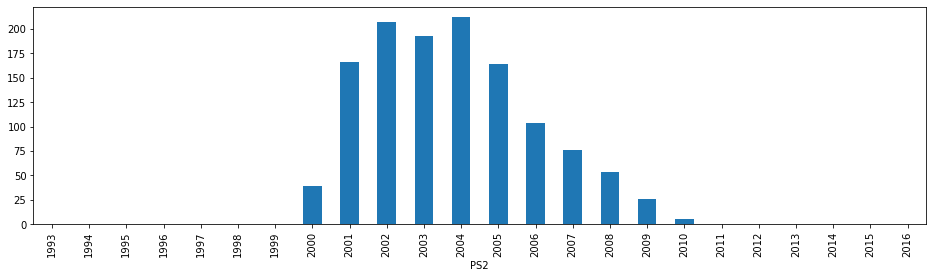

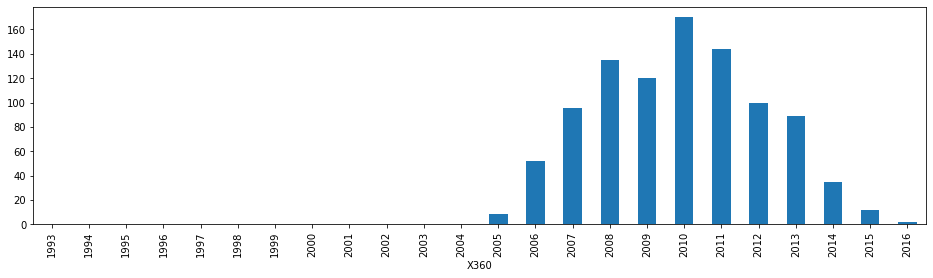

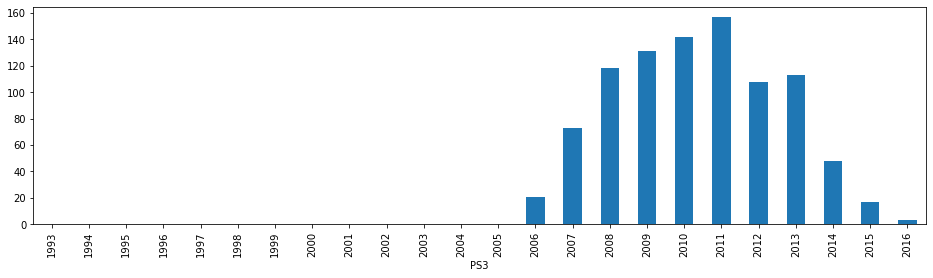

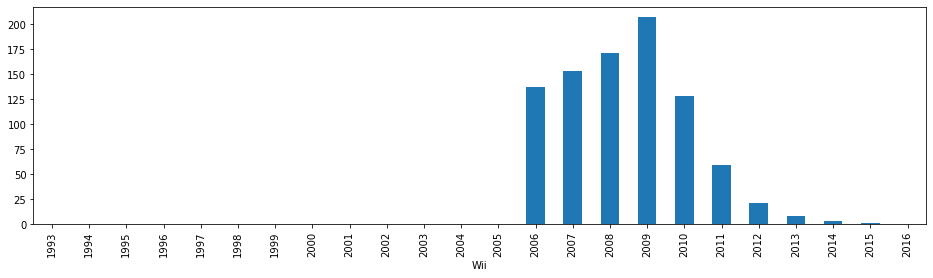

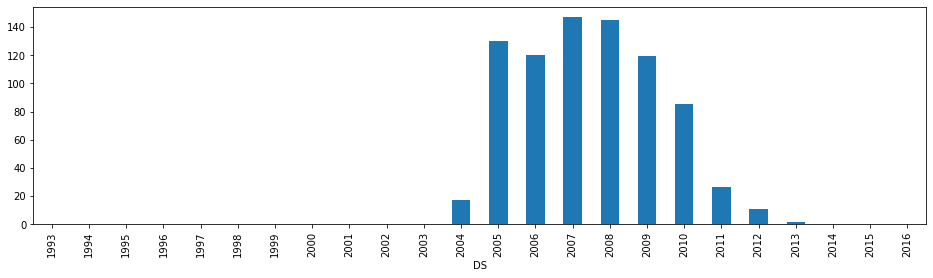

In [36]:
games_platf_year_no_all = games_platf_year_sales
games_platf_year_no_all = games_platf_year_no_all.drop(['all_time'], axis = 1)
start = 0
def bar_plotter(row, number):
    global start
    if start == number:
        return
    else:
        row.plot(x = 'year_of_release', kind = 'bar', figsize = (16,4))
        plt.xlabel(row.name)
        plt.show()
        start += 1
    
games_platf_year_no_all.apply(bar_plotter, axis = 1, args = [5])
plt.show()

Один взгляд на полученные гистограммы позволяет нам достаточно четко определить, что у каждой из приставок (особенно, с точки зрения выпуска новых игр) существует определенный срок жизни, после которого игры на неё перестают выпускать (хотя это совершенно не мешает им ещё длительное время продаваться в различных магазинах). Таким образом, тренд на "сменяемость" игровых платформ очевиден. Посчитаем, сколько в среднем "живет" (читай, "притягивает" к себе разработчиков игр") игровая приставка. Для этого найдем разницу между годом начала выпуска игр и годом окончания выпуска игр. На основании полученных данных построим гистограмму.

In [37]:
def life_calc(row):
    life_time = 0
    for year in row.index:
        if row[year] != 0: 
            life_time += 1
    return life_time
    
games_platf_year_sales['life_time'] = games_platf_year_no_all.apply(life_calc, axis = 1)
games_platf_year_sales.head(5)

year_of_release,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,all_time,life_time
platform,,,,,,,,,,,,,,,,,,,,,,,,,,
PS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.17,166.43,207.0,193.05,212.13,163.70,103.42,75.99,53.90,26.40,5.64,0.45,0.00,0.00,0.00,0.00,0.00,1247.28,12
X360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,8.25,51.63,95.41,135.26,120.29,170.08,143.84,99.74,88.58,34.74,11.96,1.52,961.30,12
PS3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,20.96,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60,931.34,11
Wii,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,137.15,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18,891.18,11
DS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,17.27,130.14,119.81,146.95,145.31,119.54,85.02,26.18,11.01,1.54,0.00,0.00,0.00,802.77,10


In [38]:
print("Максимальный срок жизни платформ, лет:", games_platf_year_sales['life_time'].max())
print("Минимальный срок жизни платформ, лет:", games_platf_year_sales['life_time'].min())

Максимальный срок жизни платформ, лет: 23
Минимальный срок жизни платформ, лет: 1


Построим гистограмму распределения сроков жизни различных платформ.

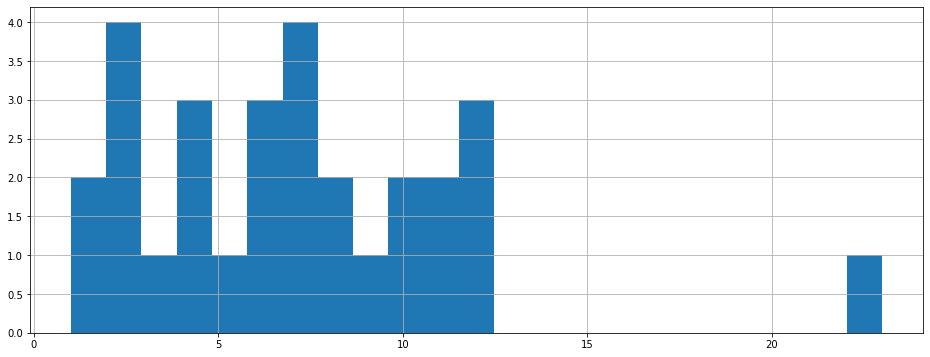

In [39]:
games_platf_year_sales['life_time'].hist(bins = 23, figsize = (16,6))

Очевидных способов получения "среднего срока жизни" платформы я не вижу. Тем не менее, в выборке присутствуют платформы с "неполным жизненным циклом" - те, у которых в 2016 году ещё были продажи. Их необходимо из этой выборки убрать. И взглянуть на ситуацию вновь. Для начала определимся, что же это за "недобитые" платформы.

In [40]:
games_platf_not_dead_2016 = games_platf_year_no_all[games_platf_year_no_all[2016] != 0]
games_platf_not_dead_2016

year_of_release,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,,,,
X360,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.25,51.63,95.41,135.26,120.29,170.08,143.84,99.74,88.58,34.74,11.96,1.52
PS3,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.96,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
Wii,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,137.15,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
PS4,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25.99,100.00,118.90,69.25
3DS,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,63.20,51.36,56.57,43.76,27.78,15.14
PC,0.0,12.87,4.22,10.58,11.27,3.26,4.74,4.66,5.47,8.57,8.84,10.39,4.37,2.85,9.28,12.42,16.91,24.28,35.03,23.57,12.38,13.28,8.52,5.25
XOne,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.96,54.07,60.14,26.15
WiiU,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.56,21.65,22.03,16.35,4.60
PSV,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.63,16.19,10.59,11.90,6.25,4.25


Таких платформ всего 9. Построим для них гистограммы распределения прибыли и посмотрим - вероятно, на 2016 год выпадает "последний" год их жизни и нам стоит их оставить в анализе.

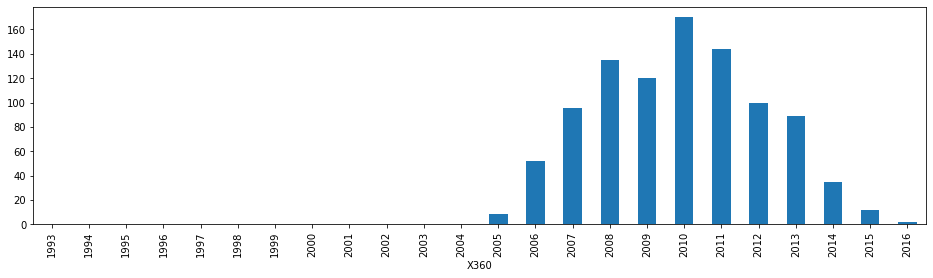

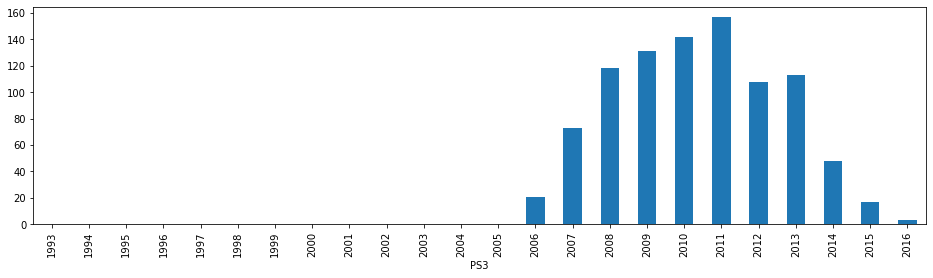

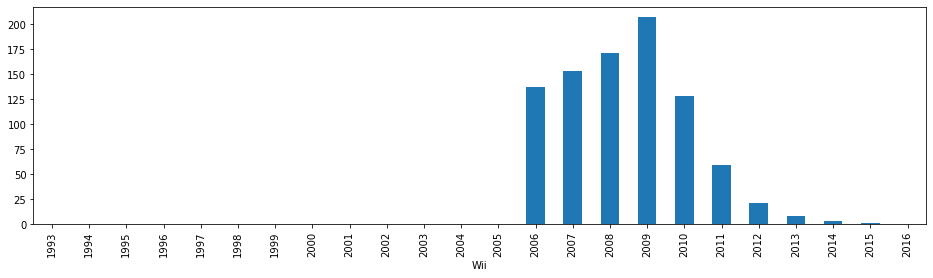

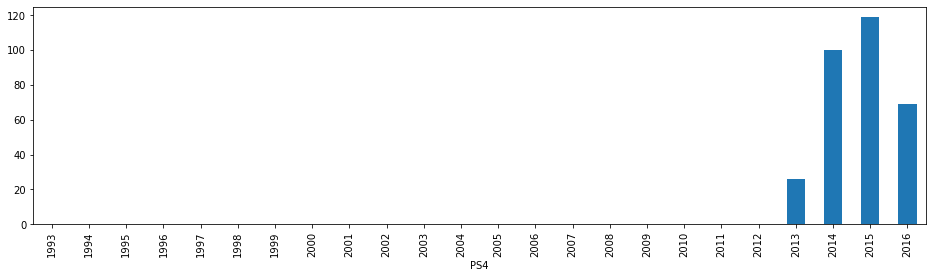

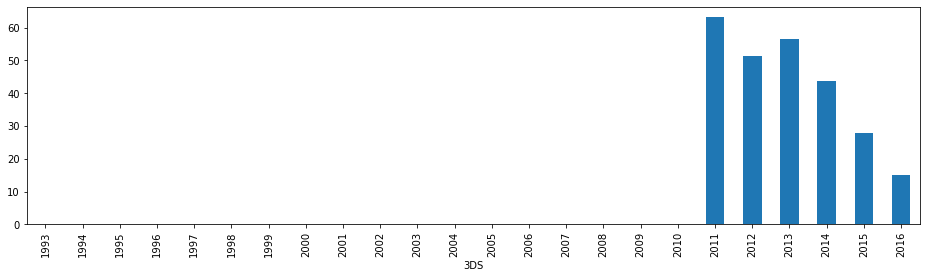

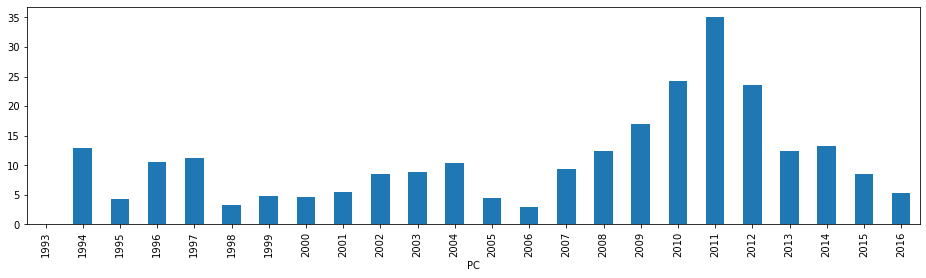

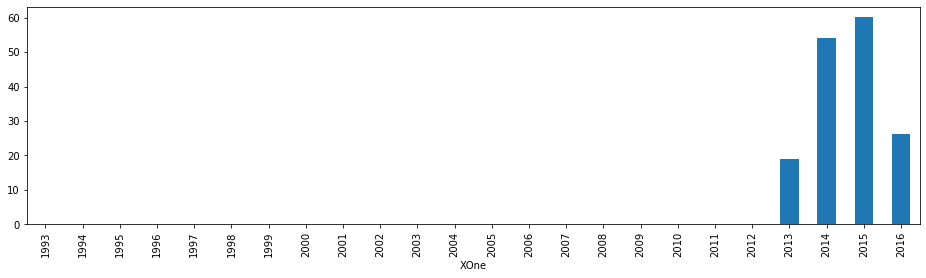

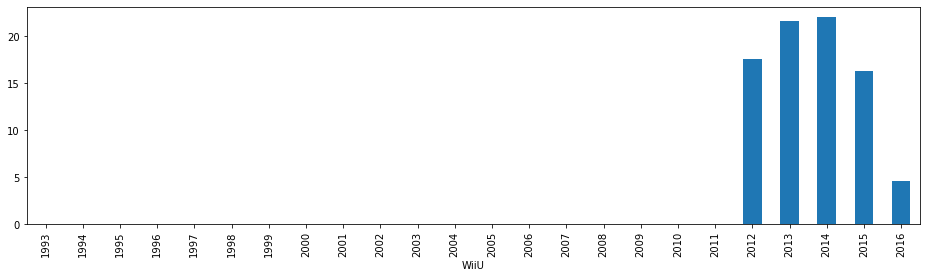

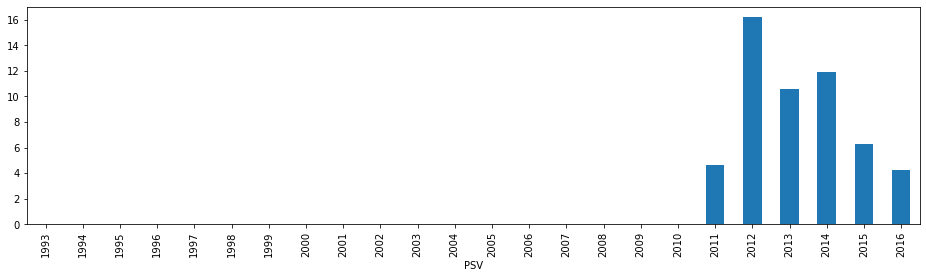

In [41]:
start = 0
games_platf_not_dead_2016.apply(bar_plotter, axis = 1, args = [9])
plt.show()

Наиболее вероятен следующий вариант событий - 3 платформы из 9 - X360, PS3 и Wii "умрут" в 2017 году. И их следует оставить в нашей выборке по годам. А вот остальные 6 платформ были весьма и весьма успешными в 2016 году - как следствие, их "гибель" маловероятна в ближайшие несколько лет (как минимум потому, что игроделы делают игры достаточно долго - особенно для широкоизвестных и крупных платформ вроде Xbox и PlayStation. Соответственно, выкидываем их значения из выборки и строим распределение ещё раз.

In [42]:
del_list = ['PS4', '3DS', 'PC', 'XOne', 'WiiU', 'PSV']
games_platf_lifetime_clean = games_platf_year_no_all.drop(del_list)
games_platf_lifetime_clean.head(5)

year_of_release,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,,,,
PS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.17,166.43,207.0,193.05,212.13,163.70,103.42,75.99,53.90,26.40,5.64,0.45,0.00,0.00,0.00,0.00,0.00
X360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,8.25,51.63,95.41,135.26,120.29,170.08,143.84,99.74,88.58,34.74,11.96,1.52
PS3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,20.96,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
Wii,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,137.15,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
DS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,17.27,130.14,119.81,146.95,145.31,119.54,85.02,26.18,11.01,1.54,0.00,0.00,0.00


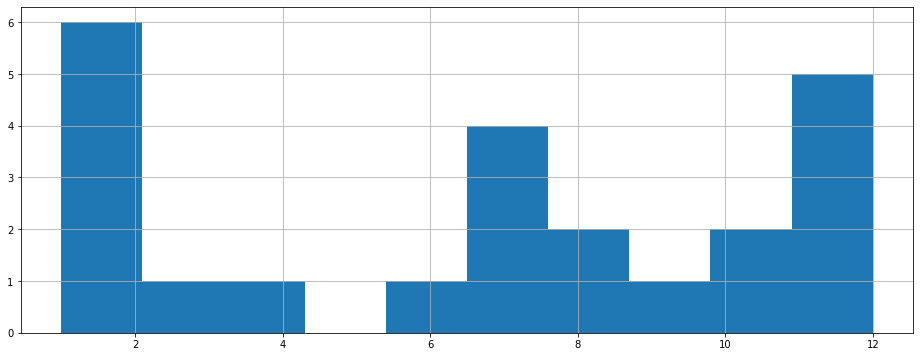

In [43]:
games_platf_lifetime_clean['life_time'] = games_platf_lifetime_clean.apply(life_calc, axis = 1)
games_platf_lifetime_clean['life_time'].hist(figsize = (16,6))

Вот теперь, избавившись от "жизнеспособных" распределение приобрело некоторый смысл. В нашем случае, смотреть на левую часть распределения совершенно бессмысленно - быстроумирающие платформы, как правило, имеют схожий показатель продаж - низкий. Проверим данное утверждение и в случае его подтверждения, избавимся также от платформ, со сроком жизни меньше 4 лет (включительно).

In [44]:
games_platf_lifetime_clean['all_time'] = games_platf_lifetime_clean.sum(axis = 1)
games_low_lifetime = games_platf_lifetime_clean[games_platf_lifetime_clean['life_time'] <= 5]['all_time']
games_low_lifetime

platform
GEN     10.78
NES      5.72
SCD      3.86
NG       5.44
WS       4.42
TG16     1.16
3DO      2.10
PCFX     1.03
Name: all_time, dtype: float64

Действительно, сборы для этих платформ крайне малы и в рамках нашего исследования на данном этапе анализа малоинтересны. Выбросим их, построим распределение финальной версии "жизнеспособности" платформ и найдем их статистические показатели.

In [45]:
games_platf_lifetime_clean = games_platf_lifetime_clean.drop(games_low_lifetime.index)

count    15.000000
mean      9.133333
std       2.133631
min       6.000000
25%       7.000000
50%       9.000000
75%      11.000000
max      12.000000
Name: life_time, dtype: float64

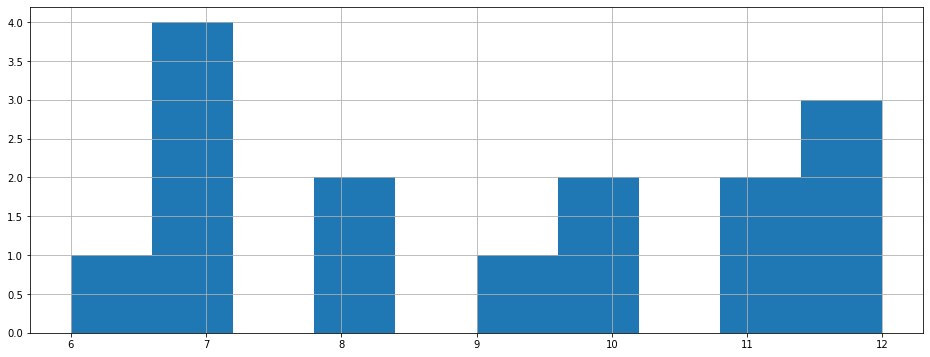

In [46]:
games_platf_lifetime_clean['life_time'].hist(figsize = (16,6))
games_platf_lifetime_clean['life_time'].describe()

Среднее значение - 9.13, медианное - 9. 
Таким образом, мы можем принять 9 лет в качестве средней продолжительности "жизни" средней игровой платформы.

## 4. Определение перспективных игровых платформ на 2017 год

На основании полученной средней продолжительности "жизни" игровой приставки - 9 лет, мы можем ограничить наш датафрейм этим значением и посмотреть более детально, что происходило в мире игровых устройств в это время. Учитывая тот факт, что сейчас на дворе конец 2016 года, нас интересуют последние 8 лет (с учетом возможности прогнозирования продаж на ближайший год) мирового игро- и приставко-строя. Уберем из нового датасета все значения, ранее 2008 года (включительно). Приставки, которые останутся "без продаж" также устраним из выборки. Проще всего это сделать, пересобрав сводную таблицу из обработанного датафрейма, полученного по итогу 2 раздела.

In [47]:
games_fill_after_2009 = games_fill_after_1993[games_fill_after_1993['year_of_release'] >= 2009]
games_actual_time = games_fill_after_2009.pivot_table(index = 'platform', columns = 'year_of_release',  
                                  values = 'sales', aggfunc = ('sum')).fillna(0)
games_actual_time

year_of_release,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,
3DS,0.00,0.00,63.20,51.36,56.57,43.76,27.78,15.14
DS,119.54,85.02,26.18,11.01,1.54,0.00,0.00,0.00
PC,16.91,24.28,35.03,23.57,12.38,13.28,8.52,5.25
PS2,26.40,5.64,0.45,0.00,0.00,0.00,0.00,0.00
PS3,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
PS4,0.00,0.00,0.00,0.00,25.99,100.00,118.90,69.25
PSP,37.78,35.04,17.82,7.69,3.14,0.24,0.12,0.00
PSV,0.00,0.00,4.63,16.19,10.59,11.90,6.25,4.25
Wii,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18


Игровых приставок, актуальных за последние 8 лет осталось совсем ничего - всего 12 штук, причем для 3 из них в последний год не было выпущено ни одной игры - следовательно и уровень продаж по ним будет существенно ниже. Нет ААА проектов, нет продаж, нет денег, нет развития платформы и т.д. до бесконечности. Эти приставки также уберем из выдачи и посмотрим на то, что осталось.

In [48]:
games_actual_time = games_actual_time.drop(['DS', 'PS2', 'PSP'])
games_actual_time

year_of_release,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,
3DS,0.00,0.00,63.20,51.36,56.57,43.76,27.78,15.14
PC,16.91,24.28,35.03,23.57,12.38,13.28,8.52,5.25
PS3,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
PS4,0.00,0.00,0.00,0.00,25.99,100.00,118.90,69.25
PSV,0.00,0.00,4.63,16.19,10.59,11.90,6.25,4.25
Wii,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
WiiU,0.00,0.00,0.00,17.56,21.65,22.03,16.35,4.60
X360,120.29,170.08,143.84,99.74,88.58,34.74,11.96,1.52
XOne,0.00,0.00,0.00,0.00,18.96,54.07,60.14,26.15


Построим для наших тщательно отобранных приставок гистограммы распределения (накопительные, по всем приставкам сразу) и посмотрим, какая из приставок оказывает наибольший вклад в итоговый "всегодовой" результат.

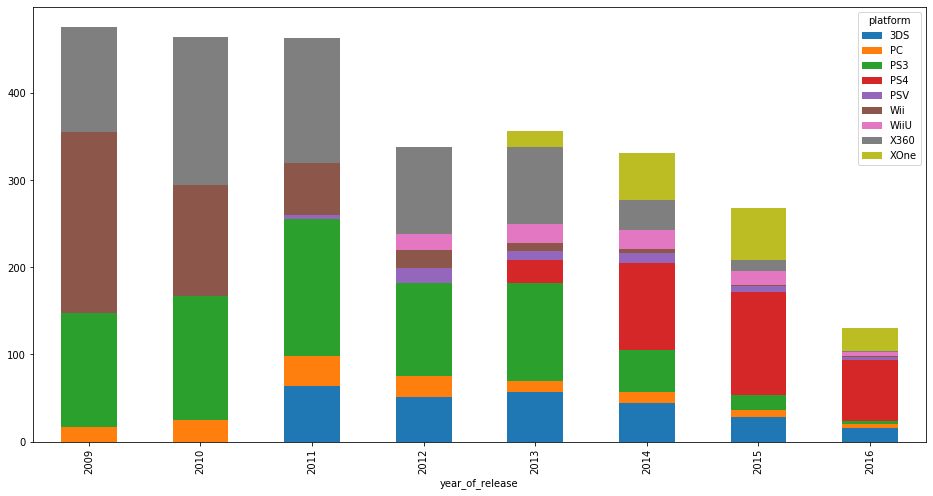

In [49]:
(games_fill_after_2009.pivot_table(index = 'year_of_release', columns = 'platform',  
                                  values = 'sales', aggfunc = ('sum'))
 .fillna(0)
 .drop(['DS', 'PS2', 'PSP'], axis = 1)
 .plot(kind = 'bar',figsize = (16,8), stacked = True) 
)

На полученной гистограмме мы наглядно видим, как происходили рост и угасание различных платформ. 

Однако, поскольку нас интересует 2017 год и прогнозы на него, уделим внимание лишь "новорожденным платформам. Как можно было заметить по гистограммам, полученным для различных платформ, общий вид распределения продаж по годам носим нормальный характер, а следовательно, пика своих значений платформы достигают в середине цикла - в возрасте 4-5 лет отроду. Проанализируем, какие из приставок будут "в самом расцвете сил" в 2017 г.

Начнем по списку из "легенды" накопительной гистограммы.

В 2011 году на рынок выходит 3DS - Nintendo 3DS. В 2017 году ей будет 7 лет - вполне подходящий возраст для "хороших продаж", однако, очевидно, что они находятся на нисходящей ветви тренда - пиковые значения прошли 2011 и 2013 гг. Дальше - только вниз. Тем не менее, её доля на рынке (за 2016 г.) находится на 3 месте, по сравнению с другими приставками - как следствие, на неё можно обратить внимание.

PC - персональный компьютер. Долгожитель на рынке платформ. Хотя продажи по отношению к общему объему рынка не так велики, на мой взгляд, это может быть "стабильной ставкой" - с учетом 23 летней истории (при 9-летней для всех остальных платформ), продажи игр для ПК всегда будут актуальны. С другой стороны, если даун- и апгрейд многих игр на приставках невозможен (например, с ПС2 на ПС4, многих - но не всех), то в случае с ПК эта история куда проще. Как следствие на ПК постоянно присутствуют игры из "Прошлой жизни" - а это, надо сказать, ощутимый конкурент новым проектам.

PS3 - PlayStation 3. Будучи лидером рынка много лет подряд, в 2016 году данная платформа переживает свой закат. В 2017 году игр будет еще меньше, как следствие, о больших объемах продаж можно даже не задумываться. R.I.P.

PS4 - PlayStation 4. Наследница PS3, появившаяся В 2013 году. 2017 должен стать годом её "пика" - как следствие, в 2017 году имеет смысл сделать ставку на данную платформу - в 2015-16 годах продажи игр для данной платформы составили более 50% от общего объема.|

В 2011 году на рынок вышла PSV - PlayStation Vita. И несмотря на "подходящий возраст (в 2017 году ей будет всего 6 лет), доля от общего объема рынка у неё минимальна - как следствие, её рассмотрение имеет смысл только в крайнем случае - при закрытии объема по другим направлениям (читай, приставкам).

Wii - Nintendo Wii. В 2017 году данной платформе будет как минимум 9 лет. Следовательно, её "лучшие времена" позади - как следствие, данную платформу не следует рассматривать в качестве персективной на 2017 г.

WiiU - Nintendo WiiU. Наследница Wii, не сыскавшая той же славы, что и её предшественница. 6 лет в 2017 году, однако продажи относительно всего рынка незначительны. Оставим в качестве "запасного варианта".

X360 - XBox 360. По аналогии с Wii - минимум 9 лет в 2017 году. У данной приставки уже есть наследник, как следствие, делать ставку на неё особого смысла не имеет. 

XOne - XBox One. Появилась одновременно с PS, занимает меньшую долю рынка по сравнению с ней, однако в 2017 году с высокой вероятностью будет переживать апогей своей "жизни". Следовательно, это также хорошая ставка на 2017 год.

Таким образом, перспективными платформами на 2017 год можно считать:
- Nintendo 3DS (3DS);
- PlayStation4 (PS4);
- XBox One (XOne);
- PC (Персональный компьютер);
- Nintendo Wii U (WiiU).

В целом, наблюдается тренд на снижение общей выручки от продаж компьютерных игр год к году.

### Зависимость продаж от платформы

Сделаем срез по полученным ранее платформам (9 шт.) и построим для него график «ящик с усами» по глобальным продажам каждой игры. 

In [50]:
games_sales_clean = games_fill_after_2009[games_fill_after_2009['platform'].isin(games_actual_time.index)]
games_sales_clean.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
2,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
6,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
11,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61,6.3,E,21.82
12,Wii Fit Plus,Wii,2009,Sports,9.01,8.49,2.53,1.77,80,7.4,E,21.80
13,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
17,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
23,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88,3.4,M,14.73
25,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0,0.0,None,14.63
26,Call of Duty: Black Ops,X360,2010,Shooter,9.70,3.68,0.11,1.13,87,6.3,M,14.62
27,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,0,0.0,None,14.60


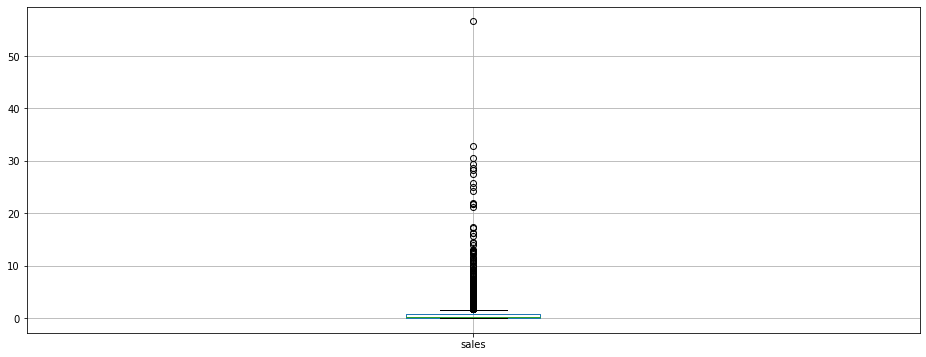

In [51]:
games_sales_clean.pivot_table(index = 'name', values = 'sales', aggfunc = 'sum').boxplot(figsize = (16,6))

Множество игр с большими объемамим продаж "вылетают" за пределы "усов" - следовательно, в выборке присутствует огромное количество игр, продажи которых по всему миру находятся крайне близко к 0.

In [52]:
games_sales_clean.pivot_table(index = 'name', values = 'sales', aggfunc = 'sum').describe()

,sales
count,3025.000000
mean,0.934165
std,2.632185
min,0.010000
25%,0.050000
50%,0.190000
75%,0.680000
max,56.580000


Как видно из статистических значений, полученных для данной выборки, более половины всех значений (а это около 1500 наименований игр) лежит в диапазоне до 190000 $ сборов по всему миру. 

Получается, что действительно, основная масса игр, выходящих в современное время "обречена" на подобные "несущественные" сборы, в то время как основную кассу "срубают" всевозможные ААА проекты от крупных студий разработчиков и "серийные игры".
А учитывая стандартное отклонение, равное 2.63 млн $, в выборке действительно присутствует некоторое число сверх больших значений.

(0, 2)

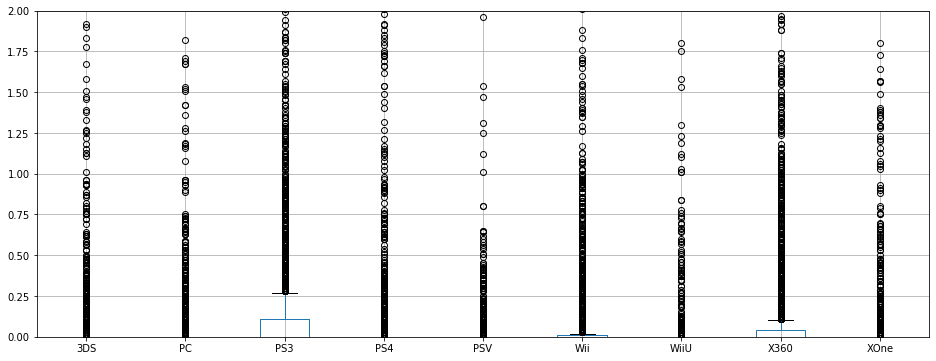

In [53]:
games_sales_clean.pivot_table(index = 'name',
                              columns = 'platform',
                              values = 'sales',
                              aggfunc = 'sum').fillna(0).boxplot(figsize = (16,6))
plt.ylim(0,2)

In [54]:
games_sales_clean.pivot_table(index = 'name',
                              columns = 'platform',
                              values = 'sales',
                              aggfunc = 'sum').describe()

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
count,512.000000,587.000000,1050.000000,392.000000,429.000000,775.000000,147.000000,853.000000,247.000000
mean,0.503535,0.237172,0.684448,0.801378,0.125431,0.554761,0.559116,0.786342,0.645020
std,1.441271,0.584988,1.444394,1.609456,0.212341,1.955028,1.058836,1.741233,1.036139
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.050000,0.020000,0.090000,0.060000,0.020000,0.080000,0.080000,0.100000,0.060000
50%,0.120000,0.060000,0.250000,0.200000,0.050000,0.180000,0.220000,0.270000,0.220000
75%,0.332500,0.190000,0.720000,0.730000,0.130000,0.440000,0.525000,0.780000,0.685000
max,14.600000,8.010000,21.050000,14.630000,1.960000,32.770000,7.090000,21.820000,7.390000


Полученные данные позволяют утверждать, что тип платформы оказывает влияние на продажи игр.
Так, для портативной PS Vita, среди всех рассматриваемых платформ соответствует минимальное значение как средней, так и медианной выручки. Также для данной платформы практически отсутствуют сильно выбивающиеся из массива значения. 

С другой стороны, не менее портативная Nintendo 3DS показывает большую среднюю выручку и наличие "хитов продаж" - максимальное значение достигает 14.6 млн. Полагаю, это связано с тем фактом, что люди не только "меняют приставки", но и продолжают покупать игры, выпущенные ранее - наиболее вероятно, средний срок "нижней границы" года покупки составляет порядка 9 лет. Как следствие, выпущенная ранее 3DS вполне логично перебивает продажи PSV. Тем не менее, сомнительно, что только этот критерий (время) является основной причиной столь высокой разницы.

PS3 - PS4, X360 - XOne, Wii - WiiU
3 пары "прародитель - приемник". При этом логика распределения значений сохраняется как в парах, так и между брендами. Приставки PlayStation - наиболее популярны. Средняя выручка больше для новой версии приставки, вероятно, по причине меньшего числа выпущенных игр. С другой стороны, медианное значение выручки для PS3 выше чем для PS4. 

Wii - наименее популярны. Выход нового поколения не привел к существенному изменению среднего значения выручки, однако, на лицо рост медианного значения. 

Xbox - в промежутке между ними. Новая консоль - меньше среднее и меньше медианное значение. 

В целом, по данным "приставочным" платформам (а все 6 описанных выше платформ это именно ПРИСТАВКИ) игр, с выручкой более 10 млн. $ относительно немного и они также "не делают погоды". И тем не менее, они есть, в отличие от игр для ПК.

Персональный компьютер стоит особняком от всех представленных в данном датасете платформ. По среднему значению выручки его нельзя отнести ни к портативным приставкам, ни к приставкам НЕпортативным. По медианному значению выручки, игры для ПК больше всего приблизились (сверху) к играм, выпущенным на PSV.

#### Наибольшей популярностью пользуются игры, выпущенные на приставках PlayStation. С ними и продолжим дальнейшую работу.

Начнем с PS3. Не забываем убрать 0 из рейтинга.

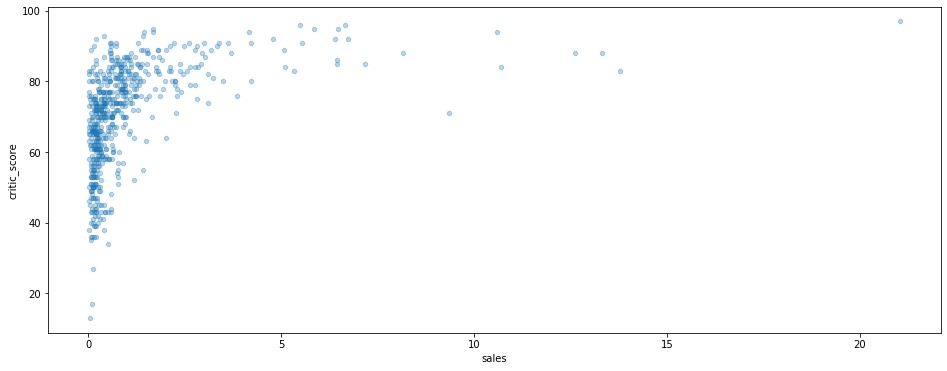

In [55]:
games_ps3_cr = games_sales_clean[(games_sales_clean['platform'] == 'PS3') & (games_sales_clean['critic_score'] != 0)]
games_ps3_cr.plot(x = 'sales', y = 'critic_score', kind = 'scatter', alpha = 0.3, figsize=(16,6))

На диаграмме рассеяния видно наличие 2 участков "зависимости" между продажами игр и оценкой критиков. С одной стороны, игры, выручка которых не превышает 1 млн. могут иметь ЛЮБУЮ оценку критиков - как очень низкую (35-40 из 100), так и очень высокую (90+). 

При этом, для игр с выручкой свыше 1 млн. рейтинг критиков практически не опускается ниже 70/100. Соответственно, можно предположить наличие корреляции между рейтингом и выручкой, хотя первичность параметров (что идёт сначала - положительные отзывы критиков или выручка - большой вопрос, требующий отдельного исследования). Рассчитаем коэффициент корреляции, убрав значения с выручкой менее 1 млн.

In [56]:
games_ps3_cr['sales'].corr(games_ps3_cr['critic_score'])

0.41797558097070253

Между продажами и оценками критиков имеет место прямая корреляция средней силы. 

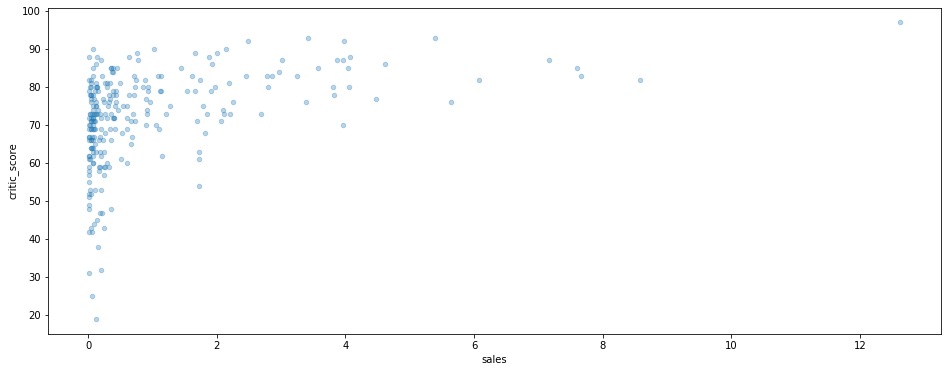

In [57]:
games_ps4 = games_sales_clean[(games_sales_clean['platform'] == 'PS4') & (games_sales_clean['critic_score'] != 0)]
games_ps4.plot(x = 'sales', y = 'critic_score', kind = 'scatter', alpha = 0.3, figsize=(16,6))

Логика распределения данных для PS4 идентичная. Смысла повторно анализировать его нет - переходим к оценкам пользователей.

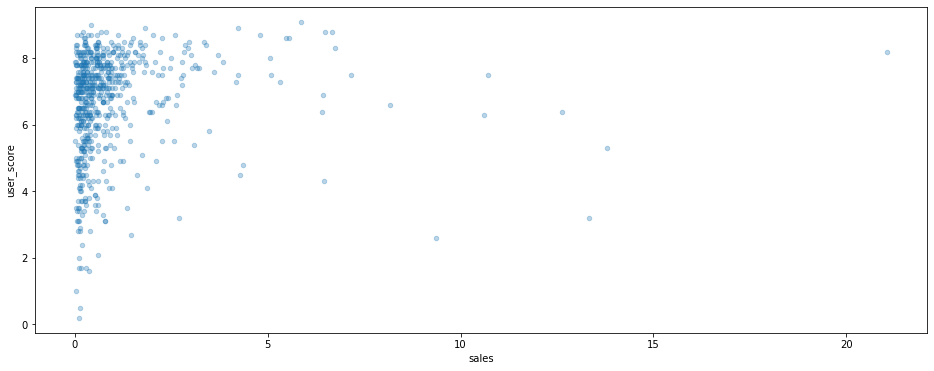

In [58]:
games_ps3_us = games_sales_clean[(games_sales_clean['platform'] == 'PS3') & (games_sales_clean['user_score'] != 0)]
games_ps3_us.plot(x = 'sales', y = 'user_score', kind = 'scatter', alpha = 0.3, figsize=(16,6))

Согласно представленным данным, критики работают более "кучно" (профессионально?) в том смысле, что отзывы пользвателей могут быть крайне "низкими", в т.ч. для игр, "собирающих кассу". Т.е. если игра собрала 10+ млн., это не значит, что пользователи будут ставить ей 10 из 10 и называть игрой века. С одной стороны, это может действительно отражать большую "честность" игроков, ведь как мы выяснилии ранее, пользовательские оценки игр, вероятнее всего, собираются из существенного числа оценок многих пользователей. 

С другой стороны, эти оценки могут быть вызваны "рейдами" или иными "мстительными актами" игроков на некоторые неугодные (зачастую всего одному блогеру или стримеру) тайтлы, выставляемые, в том числе и спустя длительное время после выхода игры. 

Тем не менее, можно сделать вывод, что подавляющее большинство покупателей игр скорее ориентируется на отзывы критиков, нежели на отзывы пользователей. Ведь все хотят покупать игры с 90% рейтинга и не покупать с 30%.

In [59]:
games_ps3_us['sales'].corr(games_ps3_us['critic_score'])

0.2830050430312348

Корреляции между рассматриваемыми параметрами нет.

Построим диаграммы рассеяния для других платформ. Напишем для этого функцию.

3DS
Коэффициент корреляции равен 0.34873973059848346


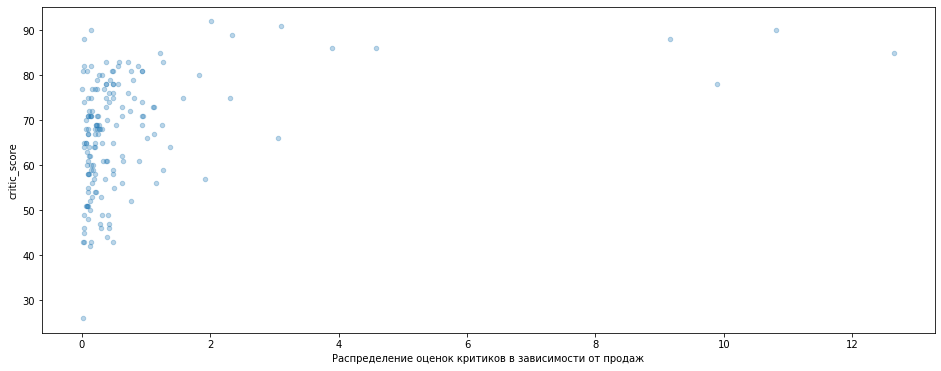

Коэффициент корреляции равен 0.22207843643390884


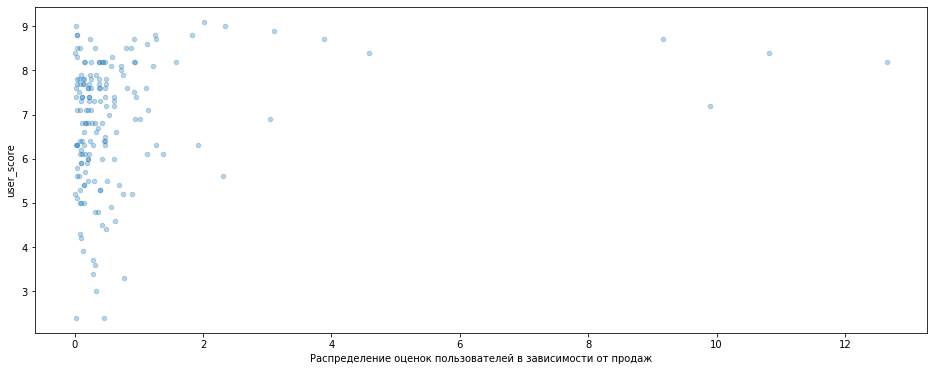

PC
Коэффициент корреляции равен 0.2971411517196228


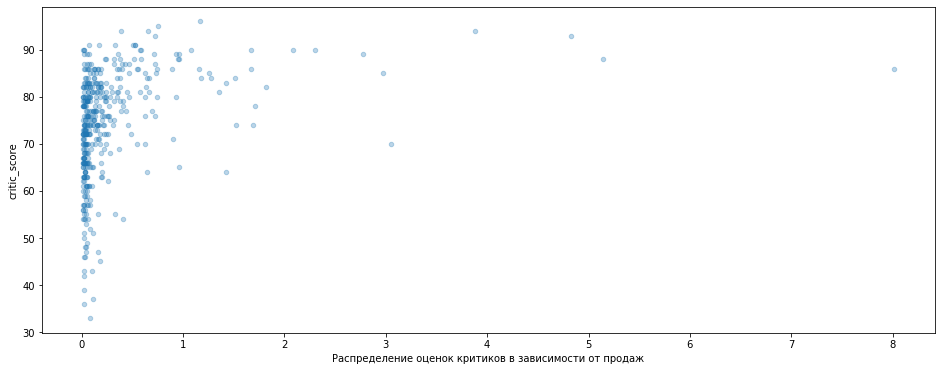

Коэффициент корреляции равен -0.011838910461749164


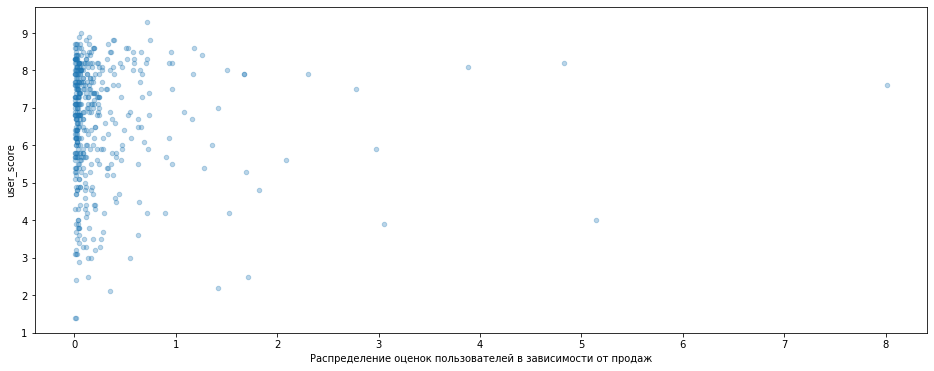

PSV
Коэффициент корреляции равен 0.13176292727608935


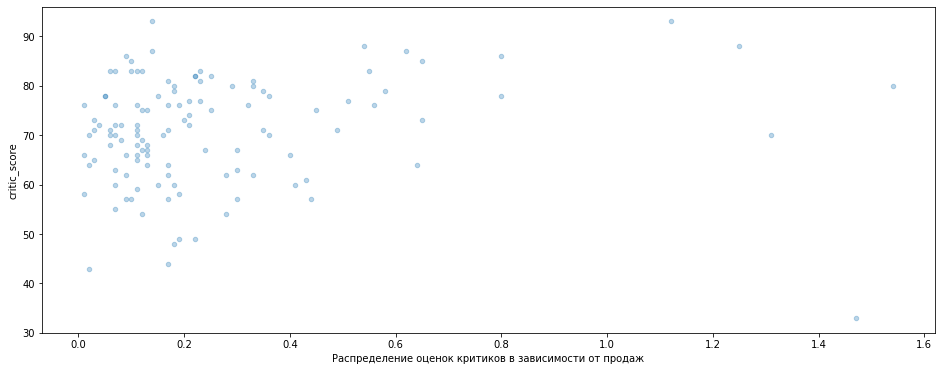

Коэффициент корреляции равен 0.013488756835886498


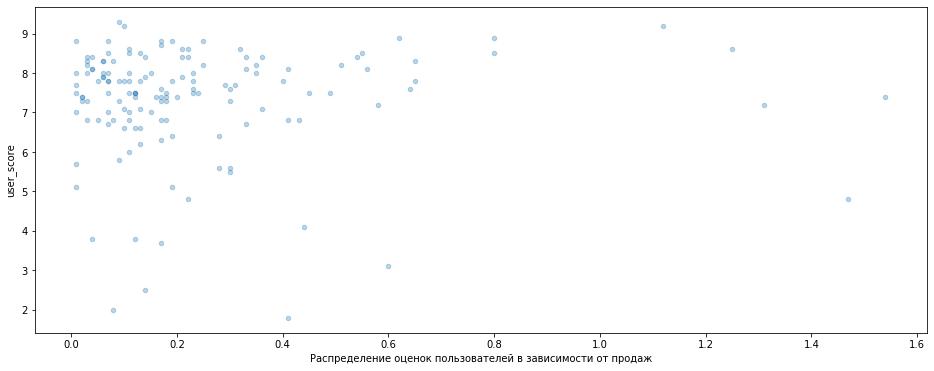

Wii
Коэффициент корреляции равен 0.22265276424142574


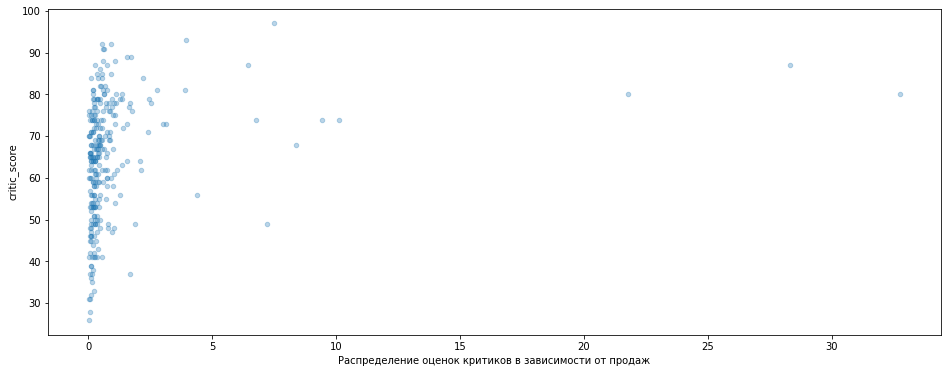

Коэффициент корреляции равен 0.11879273944952365


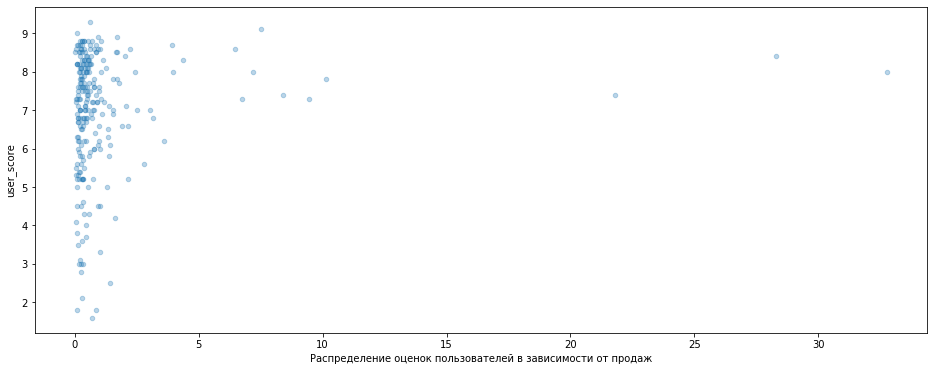

WiiU
Коэффициент корреляции равен 0.3483797601201749


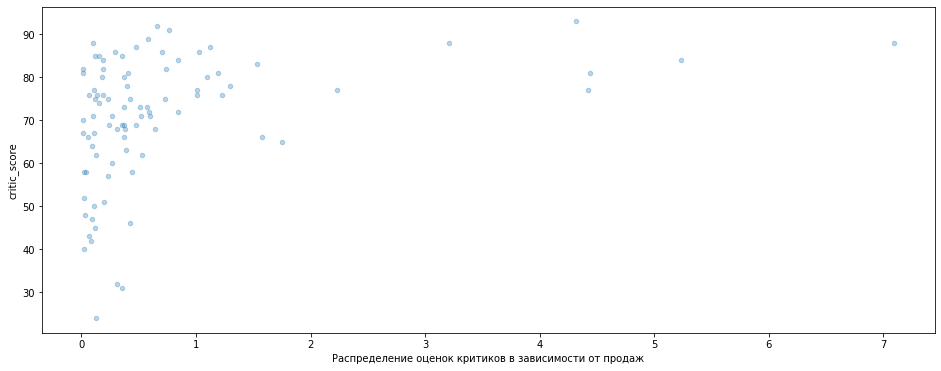

Коэффициент корреляции равен 0.4002190202148617


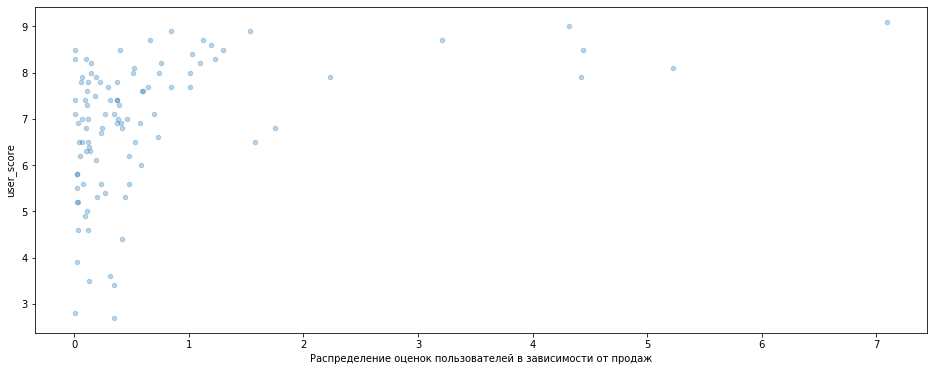

X360
Коэффициент корреляции равен 0.3644209779261909


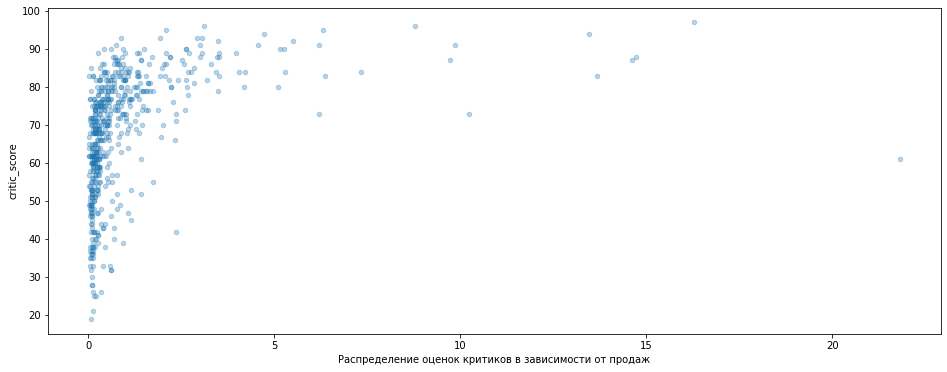

Коэффициент корреляции равен 0.08251587235626665


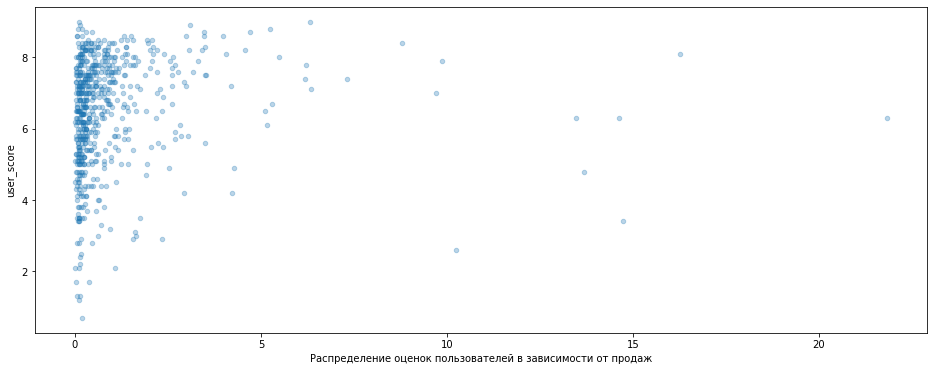

XOne
Коэффициент корреляции равен 0.41699832800840175


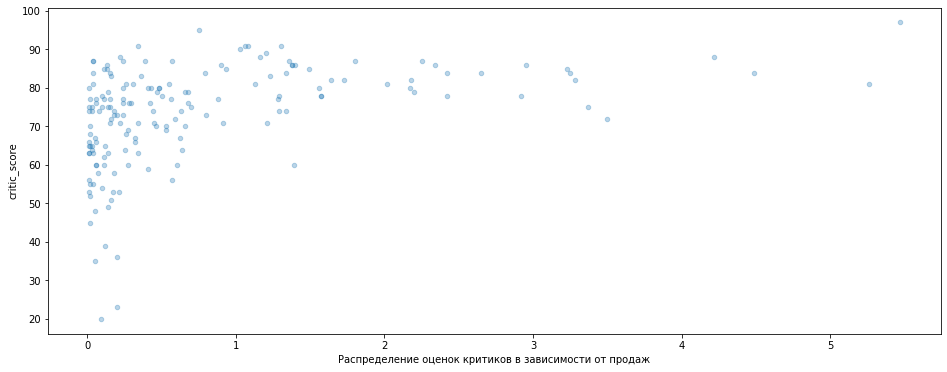

Коэффициент корреляции равен -0.06892505328279412


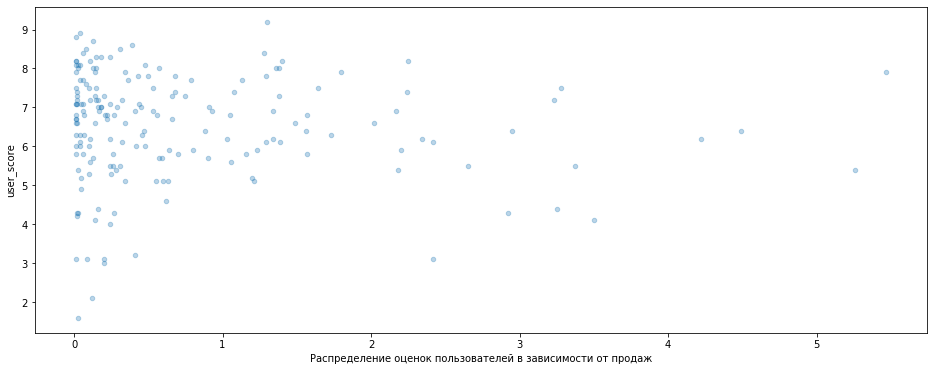

In [60]:
pltf_list = ['3DS', 'PC', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']

def scatter_plot(data, lst):
    for name in lst:
        data_clean_1 = data[(data['platform'] == name) & (data['critic_score'] != 0)]
        data_clean_2 = data[(data['platform'] == name) & (data['user_score'] != 0)]
        
        print(name)
        data_clean_1.plot(x = 'sales', y = 'critic_score', kind = 'scatter', alpha = 0.3, figsize=(16,6))
        plt.xlabel("Распределение оценок критиков в зависимости от продаж")
        print("Коэффициент корреляции равен", data_clean_1['sales'].corr(data_clean_1['critic_score']))
        plt.show()
        
        data_clean_2.plot(x = 'sales', y = 'user_score', kind = 'scatter', alpha = 0.3, figsize=(16,6))
        plt.xlabel("Распределение оценок пользователей в зависимости от продаж")
        print("Коэффициент корреляции равен", data_clean_2['sales'].corr(data_clean_2['user_score']))
        plt.show()

scatter_plot(games_sales_clean, pltf_list)

Логика зависимости продаж от рейтинга на других платформах идентична - имеется в "зачаточном" состоянии для оценок критиков и отсутствует (~0) для оценок пользователей.

### Распределение игр по жанрам

Построим гистограммы распределения игр по жанру (по количеству и выручке).

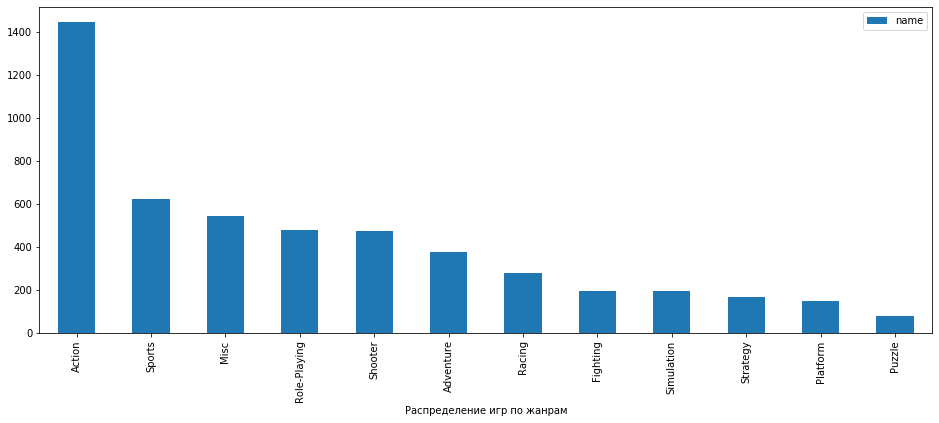

In [61]:
games_genre_count = (
    games_sales_clean.pivot_table(index = 'genre', values = 'name', aggfunc = 'count')
    .sort_values(by = 'name', ascending = False)
)

games_genre_count.plot(kind = 'bar', figsize = (16,6))
plt.xlabel("Распределение игр по жанрам")
plt.show()

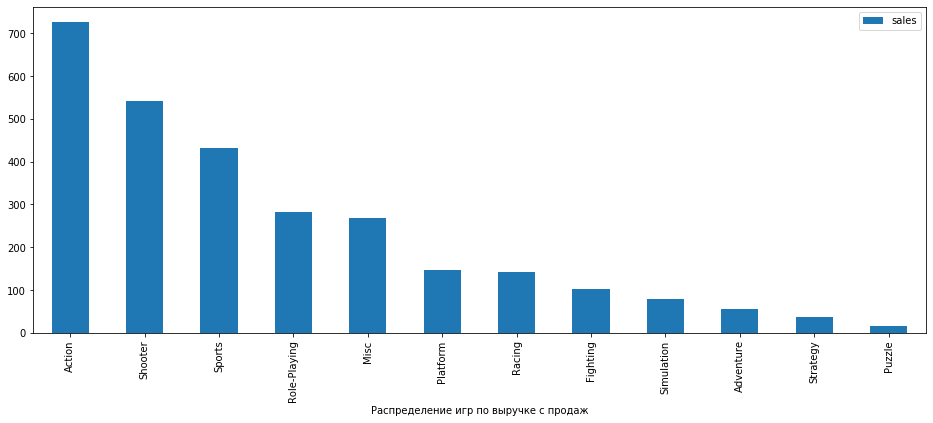

In [62]:
games_genre_sum = (
    games_sales_clean.pivot_table(index = 'genre', values = 'sales', aggfunc = 'sum')
    .sort_values(by = 'sales', ascending = False)
)
games_genre_sum.plot(kind = 'bar', figsize = (16,6))
plt.xlabel("Распределение игр по выручке с продаж")
plt.show()

Для анализа добавим ещё один столбец - средняя выручка на 1 игру, в зависимости от жанра.

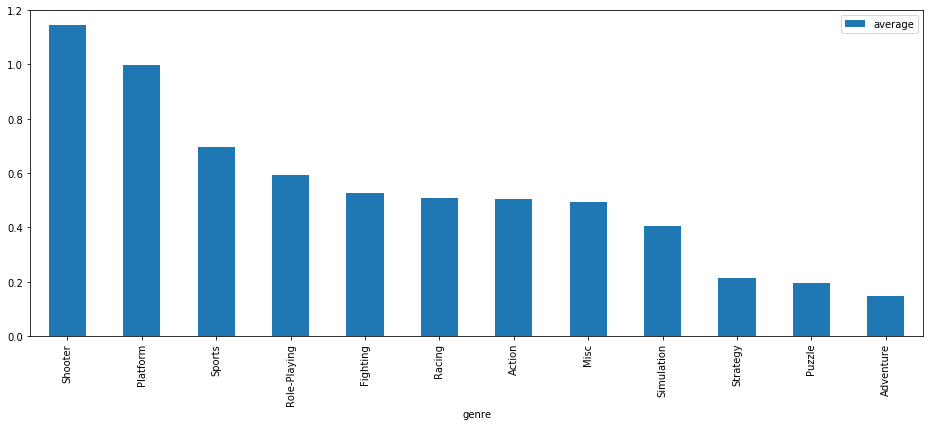

In [63]:
games_genre_count['average'] = (games_genre_sum['sales'] / games_genre_count['name'])
games_genre_count.sort_values(by = 'average',
                              ascending = False).plot(y = 'average',
                                                      kind = 'bar', 
                                                      figsize = (16,6))

Несмотря на то, что на первом месте по объему выручке и общему количеству игр находится "Экшн", первое место по выручке на игру уверенно удерживают шутеры. Не менее удивительная история и с "Платформерами" - предпоследнее место по количеству и 6 по объему выручки дают второе место по выручке на 1 игру. Третье место по данному показателю - игры жанра "Спорт". Это наименее необычный пункт - 2е место по количеству игр и 3е место по выручке. 

Последние места по числу игр, выручке и выручке на игру в 8 случаях из 9 делят игры жанров "Стратегии", "Пазлы" и "Приключения". Эти 3 категории составляют группу "дешевых игр" - их и продается меньше всего, они же приносят меньше всего выручки. Соответственно, разрабатывать игры в данных жанрах с высокой вероятностью будет экономически нецелесообразно, в отличие от жанров "Шутер" и " Платформер".

### Выводы по разделам 3 и 4

- средний срок "жизни" приставки - 9 лет. Персональный компьютер самый "долгоиграющий" - уже 23 года в строю;
- наибольшую выручку за все времена принесли игры для платформы PlayStation 2 - более 1.2 млрд. долларов;
- по состоянию на 2016 год, наибольшую выручку приносят PlayStation 4, Xbox One, Nintendo 3DS - они же являются и наиболее перспективными платформами для разработки новых тайтлов;
- наиболее популярной среди современных платформ является PlayStation 4;
- средняя выручка на одну игру по всем современным платформам составляет 190 тыс. долларов;
- имеет место общий тренд снижения выручки от продажи компьютерных игр год к году;
- средняя и медианная выручка зависит от марки платформы (Wii, PS, Xbox), типа платформы (портативная консоль, обычная консоль, ПК);
- между оценкой критиков и выручкой игры существует средняя прямая корреляция, вне зависимости от платформы. А между оценкой пользователей и выручкой корреляция, как правило, отсутствует.
- больше всего денег приносят игры жанров "Шутер" и "Платформер". Меньше всего - "Стратегии", "Пазлы" и "Приключения". Эти же игры меньше всего производят и они хуже всего продаются.

## 5. Составление портрета пользователя

Портрет пользователя в нашем исследовании определяется 2 показателями - предпочтениями по игровой приставке и жанру компьютерных игр. В качестве показателя "успешности" возьмем суммарную выручку по платформе (жанру) по региону. 

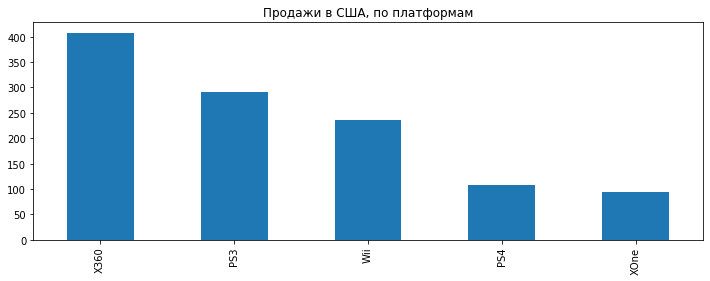

In [64]:
games_platf_region = games_sales_clean.pivot_table(index = 'platform',
                                                   values = ['na_sales', 'eu_sales', 'jp_sales'],
                                                   aggfunc = 'sum')
games_platf_region['na_sales'].sort_values(ascending = False).head(5).plot(kind = 'bar',
                                                          title = 'Продажи в США, по платформам', 
                                                                           figsize = (12,4))
plt.xlabel('')
plt.show()

На территории США наибольшую популярность приобрели приставки серии Xbox - в первой пятерки они занимают 1 и 5 место по общему объему выручки. Данное расположение наиболее полно раскрывается в сравнении с парой других приставок-родственников - PS4 и PS3. Несмотря на то, что выручка по играм для приставки PS3 на территории США оказалась ниже аналогичного значения для аналога от Майкрософт, приставка PS4 характеризуется наибольшим потенциалом "повышения выручки" в ближайшие несколько лет, учитывая важность "возраста" приставки на рынке. 
"Наследник" приставки Wii - WiiU отсутствует в нашем списке; как следствие, перспективы развития данной платформы на рынке США хуже чем у конкурентов. Портативные консоли и ПК гейминг на территории США распространены куда уже полноразмерных консолей.

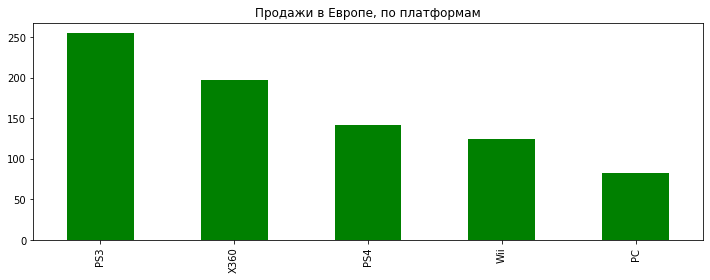

In [65]:
games_platf_region['eu_sales'].sort_values(ascending = False).head(5).plot(kind = 'bar',
                                                          title = 'Продажи в Европе, по платформам',
                                                                           figsize = (12,4), color = 'g')
plt.xlabel('')
plt.show()

На европейском рынке непревзойденным лидером, согласно имеющимся данным, является платформа PlayStation. В "общем зачете" платформы PS3 и Xbox 360 поменялись местами, а платформу PS4 по аналогии с рынком США по-прежнему можно рассматривать в качестве наиболее "потенциированной" по сравнению с конкурентами. 

На этом рынке на 5е место взобрался ПК гейминг, однако, перспектив подняться выше у него, к сожалению, мало. Ситуация с Wii идентичная американскому рынку, портативных консолей в нашем топе также не видно.

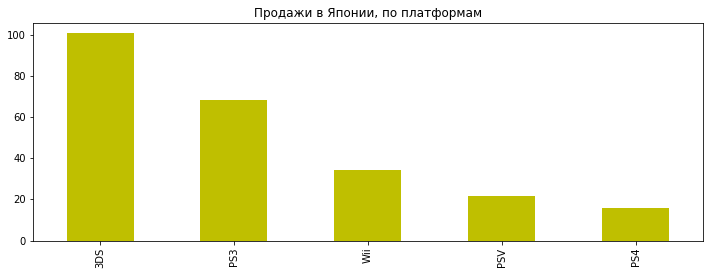

In [66]:
games_platf_region['jp_sales'].sort_values(ascending = False).head(5).plot(kind = 'bar',
                                                          title = 'Продажи в Японии, по платформам',
                                                                           figsize = (12,4), color = 'y')
plt.xlabel('')
plt.show()

Японский рынок в очередной раз удивляет (и это уже перестает быть удивительным). В отличие от остальных стран здесь в пятерке оказались обе консольные приставки - Nintendo 3DS и PS Vita, причем сразу на 1 и 4 местах соответственно. Причиной этого факта можно считать определенную "своеобразность" игрового рынка Японии, проявляющуюся, например, в существовании такого жанра, как JRPG или "Японские RPG", такие как Final Fantasy и иже с ними. Имея достаточно сдержанные успехи на мировом рынке, в Японии игры этой серии находятся в ранге "мессии" - на них молятся, их любят люди всех возрастов и т.д. 

Более глубокие и точные причины возникновения подобного "расхождения" определить достаточно сложно. К тому же, всегда можно свалить на "менталитет" :)

Проведем аналогичную работу с точки зрения жанрового распределения по регионам.

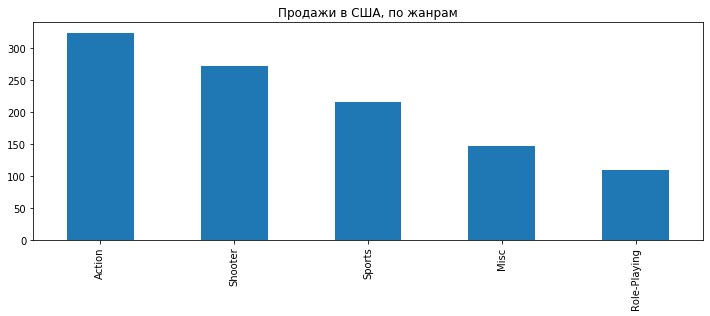

In [67]:
games_genre_region = games_sales_clean.pivot_table(index = 'genre',
                                                   values = ['na_sales', 'eu_sales', 'jp_sales'],
                                                   aggfunc = 'sum')
games_genre_region['na_sales'].sort_values(ascending = False).head(5).plot(kind = 'bar',
                                                          title = 'Продажи в США, по жанрам', 
                                                                           figsize = (12,4))
plt.xlabel('')
plt.show()

Первое место - игры в жанре "экшн". Наряду с "шутерами" и играми жанра "спорт", наличие игр этих 3 жанров на первых местах объяснить достаточно просто, если принять в качестве отправной точки предположение, что с помощью компьютерных игр люди решают некоторые свои задачи. Например, как в нашем случае, такой задачей может быть получение эмоций, которых в других местах люди получить не могут. Ведь гораздо проще запустить игру, в которую УЖЕ вшиты "эмоции, переживания, ощущения, страх, гнев и т.п.", чем жить "полной жизнью" и собственной жизнью делать тоже самое. Люди хотя эмоций, люди хотят ощущений и переживаний, но трудиться для этого не хотят. Потому - "экшн", "шутеры" и "спорт". Аналогичная ситуация и с играми жанра "РПГ" - отыгрывание некой "другой" жизни - попытка "сбежать" из существующей, скучной и несовершенной жизни. Вероятно по той же причине в нашем топе содержится группа игр жанра "другие".

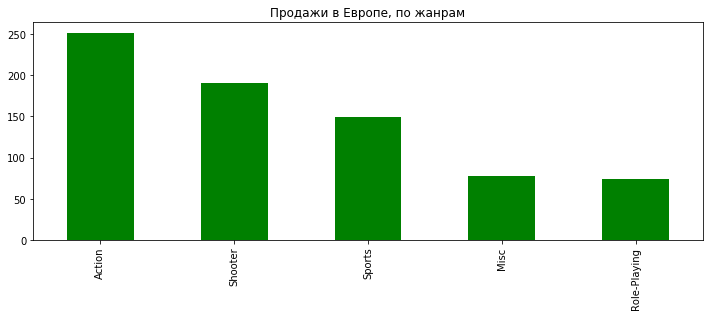

In [68]:
games_genre_region['eu_sales'].sort_values(ascending = False).head(5).plot(kind = 'bar',
                                                          title = 'Продажи в Европе, по жанрам', 
                                                                           figsize = (12,4), color = 'g')
plt.xlabel('')
plt.show()

Территория другая, но задачи, которые люди решают с помощью компьютерных игр те же. Расположение, порядок и примерное распределение по объему продаж идентичны данным, полученным для США. Переходим к Японии.

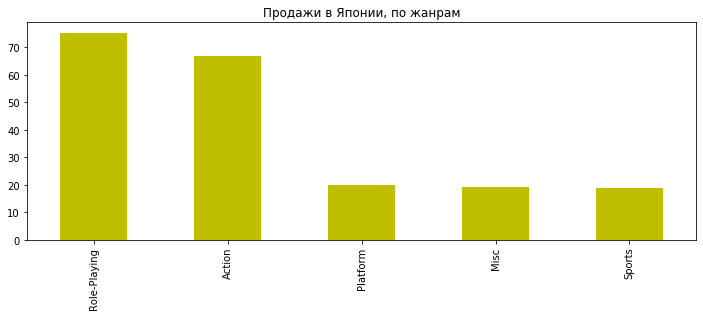

In [69]:
games_genre_region['jp_sales'].sort_values(ascending = False).head(5).plot(kind = 'bar',
                                                          title = 'Продажи в Японии, по жанрам', 
                                                                           figsize = (12,4), color = 'y')
plt.xlabel('')
plt.show()

Игры жанр "экшн" вновь в самом начале списка, пусть и на втором месте (отрыв между 1 и 2 место куда меньше, чем между 2 и 3). В целом, пусть и в иной последовательности, но список воспроизведен идентично другим зонам в 4 из 5 случаев. "Новый" жанр в перечне - "платформеры". Япония, родина компании Нинтендо, производящей аналогичные приставки, также является родиной самого первого, (а если это не так, то) самого популярного платформера в мире - Марио. Думаю игры про Марио занимают существенную долю в столбце "платформеры". Вероятно в этом и заключается причина появления данного жанра в списке.

### Влияние рейтинга игр на продажи в различных регионах

Влияет ли возрастной рейтинг на то, как продаются игры? Узнаем, построив гистограмму распределения значений выручки в зависимости от рейтинга для каждого из регионов.

In [70]:
games_sales_clean_rate = games_sales_clean[games_sales_clean['rating'] != "None"]
games_sales_clean_rate.pivot_table(index = 'rating',
                                   values = ['na_sales','eu_sales'],
                                   aggfunc = 'sum').sort_values(by = 'na_sales',ascending = False)

,eu_sales,na_sales
rating,,
M,323.74,437.53
E,232.43,334.02
T,147.11,213.24
E10+,105.45,174.00


С одной стороны, по имеющимся данным сложно точно установить подобное влияние - мы можем только выдвинуть гипотезу и НЕ найти для неё противоречий. 
Для США и Европы логика распределения выручки в зависимости от жанра имеет идентичную структуру - лучше (больше) всего продаются игры категории М (17+), затем идут игры "для всех" - Е, затем игры "для подростков" - Т (13+). В дополнение, посмотрим на количество игр каждого из возрастных рейтингов и сформулируем выводы относительно полученных результатов.

In [71]:
games_sales_clean_rate.pivot_table(index = 'rating',
                                   values = ['na_sales','eu_sales'],
                                   aggfunc = 'count').sort_values(by = 'na_sales',ascending = False)

,eu_sales,na_sales
rating,,
T,980,980
E,928,928
M,819,819
E10+,630,630


Логика лидерства игр 17+ очевидна - больше "эмоций на квардратный сантиметр действа" (как говорил известный интернет-персонаж - "убийства, матюки и голые ..."). К тому же наибольшие продажи обеспечивает платежеспособная аудитория. Ведь сколько бы мы не говорили про бескорыстность наших поступков (покупая что-либо для младших членов семьи):

- мы скорее купим им что-то "полезное" (а компьютерные игры к "полезному" относятся крайне редко);
- для себя что-то "не очень полезное" мы покупаем чаще и охотнее (привет "шутеры").

Игры жанра "спорт" и "другое" скорее всего во многом формируют "кассу" рейтинга Е (для всех) - их лидерство среди жанров мы утвердили ранее.

In [72]:
games_sales_clean_rate.pivot_table(index = 'rating',
                                   values = 'jp_sales',
                                   aggfunc = 'sum').sort_values(by = 'jp_sales',ascending = False)

,jp_sales
rating,
E,54.34
T,42.18
M,34.20
E10+,11.54


Распределение для Японии носит иной характер. Самые продаваемые - игры "Для всех" (вспоминаем про популярность в Японии платформеров). Дальше идут игры 13+ (привет, РПГ) и 17+ (привет, "Экшн"). Игры "Для всех, от 10 лет" снова на последнем месте.

## 6. Проверка статистических гипотез

### Гипотеза №1
Первая гипотеза, которую необходимо проверить: 

<font color='red'>Средние пользовательские рейтинги платформ Xbox One и PC одинаковые</font>

Сформулируем нулевую гипотезу следующим образом:

<font color='red'>H0 = "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые".</font>

Альтернативная гипотеза будет иметь следующий вид:

<font color='red'>H1 = "Средние пользовательские рейтинги платформ Xbox One и PC различаются".</font>

Применяя метод ttest_ind, для сравнения двух генеральных совокупностей по взятым из них выборкам, я подумал по поводу необходимости использования параметра "equal_var". Принял решение передать ему значение False (не делать дисперсии г.совокупностей одинаковыми) в связи с существенным различием дисперсий исследованных ранее выборок для различных тарифов.

In [73]:
games_user_rate_clean = games_sales_clean[games_sales_clean['user_score'] != 0]

games_xboxone = games_user_rate_clean[games_user_rate_clean['platform'] == 'XOne']
games_pc = games_user_rate_clean[games_user_rate_clean['platform'] == 'PC']

games_result = st.ttest_ind(games_xboxone['user_score'], 
                            games_pc['user_score'], 
                            equal_var = False)
games_result.pvalue

0.2838075863670499

Имея вероятность случайного возникновения среднего значения выборки в 28+ процентов, мы не можем отклонить нулевую гипотезу. Потому, она остается в качестве "рабочей версии происходящего", а значит:

>Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

### Гипотеза №2
Вторая гипотеза, которую необходимо проверить: 

>Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные

Тогда нулевая гипотеза будет звучать как:

>H0 = "Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые"

Альтернативная гипотеза будет иметь вид:

>H1 = "Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные"

In [74]:
games_action = games_user_rate_clean[games_user_rate_clean['genre'] == 'Action']
games_sports = games_user_rate_clean[games_user_rate_clean['genre'] == 'Sports']

games_result_2 = st.ttest_ind(games_action['user_score'], 
                            games_sports['user_score'], 
                            equal_var = False)
games_result_2.pvalue

4.1552218384334934e-14

Вероятность случайного возникновения отклонения крайне мала - меньше 5, 1 и даже 0.01%. Следовательно, мы отвергаем нулевую гипотезу и принимаем альтернативную гипотезу. Следовательно:

>H1 = "Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные"


## 7. Общие выводы

Целью проекта является:
>Выявление критериев, оказывающих наибольшее влияние на "успешность" компьютерных игр.

Переформулируем цель следующим образом - необходимо задать "курс", в соответствии с которым компания будет осуществлять выбор и реализацию компьютерных игр. 

1.Несмотря на существующий тренд на тот факт, что объем продаж игр (как и их количество), выпущенных после 2008 года, неуклонно падает, можно предположить, что 2017-2018 года станут годами разворота тренда - в сторону роста. Это можно предположить, основываясь на факте, что имеющиеся значения выручки напрямую зависят от их возраста - чем дольше игра (игровая платформа) на рынке, тем выше её продажи.

В 2015 году выпущено 606 игр.
На конец 2016 года, игр 2015 года выпуска продано на 267.98 млн.$

В 2016 году выпущено 502 игры.
На конец 2016 года, игр 2016 года выпуска продано на 129.94 млн.$

2.Средний срок жизни игровой платформы составляет порядка 9 лет. Персональный компьютер - единственный представитель, остающийся на рынке в течение 23 лет.


3.В настоящий момент на рынке присутствует 9 игровых платформ, находящихся в той или иной стадии жизненного цикла. 3 платформы - PS3, Xbox 360, Nintendo Wii находятся на финальной стадии своего существования - для них перестают выпускать игры, падают продажи и т.д. 3 платформы - PS4, Xbox One и Nintendo Wii U находятся на восходящей ветви своего существования - в ближайшие 2 года продажи по данным направлениям и число выпущенных игр будут максимальными. Имеет смысл обратить внимание на эти 3 платформы. 2 платформы - PS Vita и Nintendo 3DS - портативные консоли  - находятся на нисходящей ветви жизненного цикла - прямо за пиковыми значениями продаж. Данные платформы не характеризуются высокими средними "чеками" и суммарными продажами, однако, с точки зрения жизненного цикла, работа с этими платформами, несомненно, имеет смысл. Последняя платформа - "Персональный компьютер", ПК, является нетипичным участником данного списка. У него отсутствует жизненный цикл как таковой, однако по графику продаж игр, выпущенных в различные годы, можно предположить скорый разворот тренда в сторону повышения числа выпущенных игр и получаемой выручки. Таким образом, с точки зрения жизненного цикла,в 2017 году выбор следует сделать в пользу следующих платформ (по убыванию приоритета): PS4, Xbox One, Nintendo Wii U, персональный компьютер, Nintendo 3DS, PS Vita. 


4.С точки зрения выручки, в 2017 году выбор следует сделать в пользу следующих платформ (по убыванию приоритета): PS4, Xbox One, Nintendo 3DS, персональный компьютер, Nintendo Wii U.


5.С точки зрения значения средней выручки на 1 игру, наибольший интерес представляют платформы PS4 и Xbox One.


6.Установлено наличие прямой корреляции средней силы (по нижней границе) между отзывами критиков и продажами компьютерных игр. В свою очередь, корреляция между отзывами пользователей и продажами игр как правило существенно ниже - игры собирающие "много" могут иметь как "высокую", так и "низкую" оценку пользователей. Таким образом, можно утверждать, что выбор в пользу игр, получивших высокие оценки критиков станет более экономически целесообразным (с точки зрения выручки) в 2017 году. 


7.C точки зрения выручки, в среднем, больше всего денег (на 1 игру) приносят игры жанров "Шутер",  "Платформер" и "Спорт". Меньше всего - игры жанров "Стратегия", "Пазлы" и "Приключения". Эти же игры меньше всего производят и они хуже всего продаются.

Обобщая полученные выводы с точки зрения регионального подхода:

1.Для компаний, ориентированных на рынок США, рекомендуется сделать "упор" на игры жанров "Экшн", "Шутер" и "Спорт", выпускаемые для платформ PS4 и Xbox One. Рекомендуемый рейтинг игр - M (17+) и E (0+);


2.Для компаний, ориентированных на рынок Европеских стран, рекомендуется сделать "упор" на игры жанров "Экшн", "Шутер" и "Спорт", выпускаемые для платформ PS4, ПК и Xbox One. Рекомендуемый рейтинг игр - M (17+) и E (0+);


3.Для компаний, ориентированных на рынок Японии, рекомендуется сделать "упор" на игры жанров "РПГ", "экшн" и "Платформер", выпускаемые для платформ Nintendo 3DS, PS Vita и PS4. Рекомендуемый рейтинг игр E (0+) и T (13+)

Для всех регионов рекомендуется выбирать игры с высоким рейтингом критиков.